## Data Preperation for Linear Model

### Loading

In [42]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime,timedelta
import pandas.api.types as ptypes

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import display

from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan

In [43]:
status_final = pd.read_csv(r'C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Assign to Parking Lots Data\2024-02_Assign to parkinglot_Final_Status.csv')
weather_original = pd.read_csv(r'C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Final Weather\2024-02_Final_Weather.csv')

# status_final = pd.read_csv(r'C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Assign to Parking Lots Data\merged_parking_data_2023_2025.csv')
# weather_original = pd.read_csv(r'C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Final Weather\merged_weather_data_2023_2025.csv')

trips = status_final
weather = weather_original

In [44]:
print("STEP 0 - DataFrames loaded:")
print("trips shape:", trips.shape)
print("weather shape:", weather.shape)

STEP 0 - DataFrames loaded:
trips shape: (6334, 12)
weather shape: (1297, 7)


### STEP 1 - Prepare trips data at hourly resolution

In [45]:
# =========================================================
# STEP 1 - Prepare trips data at hourly resolution
# =========================================================

# 1.1 Ensure start_time is datetime
trips['start_time'] = pd.to_datetime(trips['start_time'], errors='coerce')

# 1.2 Keep only trip_start events (if the column exists)
if 'event_types' in trips.columns:
    trips_start_hr = trips[trips['event_types'] == 'trip_start'].copy()
else:
    trips_start_hr = trips.copy()

# 1.3 Floor to hour → this will be the time key for merging with weather
trips_start_hr['datetime_hour'] = trips_start_hr['start_time'].dt.floor('H')
trips_start_hr['date'] = trips_start_hr['datetime_hour'].dt.date
trips_start_hr['hour'] = trips_start_hr['datetime_hour'].dt.hour  # 0..23

print("\nSTEP 1 - trips_start_hr with datetime_hour/date/hour (sample):")
display(trips_start_hr[['start_time', 'datetime_hour', 'date', 'hour']].head())


STEP 1 - trips_start_hr with datetime_hour/date/hour (sample):


C:\Users\etaiw\AppData\Local\Temp\ipykernel_20596\3045977678.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  trips_start_hr['datetime_hour'] = trips_start_hr['start_time'].dt.floor('H')


,start_time,datetime_hour,date,hour
1,2024-02-02 03:34:13,2024-02-02 03:00:00,2024-02-02,3
5,2024-02-13 19:53:39,2024-02-13 19:00:00,2024-02-13,19
7,2024-02-01 16:14:52,2024-02-01 16:00:00,2024-02-01,16
9,2024-02-12 14:01:11,2024-02-12 14:00:00,2024-02-12,14
11,2024-02-21 17:27:17,2024-02-21 17:00:00,2024-02-21,17


### STEP 2 - Aggregate trips to trips_per_hour (target y)

In [46]:
# =========================================================
# STEP 2A - Prepare hourly weather from raw weather_original
# =========================================================

# Start from the original clean weather dataframe
weather = weather_original.copy()

# Make sure 'datetime' is really datetime dtype
weather['datetime'] = pd.to_datetime(weather['datetime'], errors='coerce')

# Floor to hour resolution
weather['datetime_hour'] = weather['datetime'].dt.floor('H')

# Aggregate to hourly weather
hourly_weather = (
    weather
      .groupby('datetime_hour')
      .agg(
          temp_c      = ('temp_c', 'mean'),
          temp_max_c  = ('temp_max_c', 'mean'),
          temp_min_c  = ('temp_min_c', 'mean'),
          wind_speed_ms = ('wind_speed_ms', 'mean'),
          rain_mm     = ('rain_mm', 'sum'),
      )
      .reset_index()
)

print("\nSTEP 2A - hourly_weather (first rows):")
display(hourly_weather.head())
print("\nSTEP 2A - hourly_weather shape:", hourly_weather.shape)



STEP 2A - hourly_weather (first rows):


C:\Users\etaiw\AppData\Local\Temp\ipykernel_20596\2694457965.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather['datetime_hour'] = weather['datetime'].dt.floor('H')


,datetime_hour,temp_c,temp_max_c,temp_min_c,wind_speed_ms,rain_mm
0,2024-02-01 00:00:00,9.566667,9.75,9.45,2.750000,0.0
1,2024-02-01 01:00:00,9.266667,9.40,9.15,2.800000,0.0
2,2024-02-01 02:00:00,10.583333,11.40,9.35,5.100000,0.0
3,2024-02-01 03:00:00,12.766667,13.00,12.55,7.300000,0.0
4,2024-02-01 04:00:00,12.650000,13.00,12.35,8.183333,0.0



STEP 2A - hourly_weather shape: (649, 6)


In [47]:
# =========================================================
# STEP 2B - Aggregate trips to trips_per_hour (target y)
# =========================================================

hourly_trips = (
    trips_start_hr
    .groupby('datetime_hour')
    .size()
    .rename('trips_per_hour')
    .reset_index()
)

print("\nSTEP 2B - hourly_trips (first rows):")
display(hourly_trips.head())

print("\nSTEP 2B - hourly_trips shape:", hourly_trips.shape)
print("\nSTEP 2B - trips_per_hour summary:")
display(hourly_trips['trips_per_hour'].describe().to_frame(name='trips_per_hour_stats'))



STEP 2B - hourly_trips (first rows):


,datetime_hour,trips_per_hour
0,2024-02-01 00:00:00,2
1,2024-02-01 01:00:00,1
2,2024-02-01 06:00:00,1
3,2024-02-01 09:00:00,4
4,2024-02-01 10:00:00,3



STEP 2B - hourly_trips shape: (526, 2)

STEP 2B - trips_per_hour summary:


,trips_per_hour_stats
count,526.000000
mean,5.553232
std,4.754549
min,1.000000
25%,2.000000
50%,4.000000
75%,8.000000
max,23.000000


### STEP 3 - Build full hourly panel and merge trips (with interpolation time based)
Interpolation = fills missing or intermediate values by estimating them from surrounding data points

In [48]:
# =========================================================
# STEP 3 - Build full hourly panel and merge trips (with interpolation)
# =========================================================

from IPython.display import display

# 3.1 Define full hourly range based on weather datetime_hour
start_hour = weather['datetime_hour'].min().floor('H')
end_hour   = weather['datetime_hour'].max().ceil('H')

full_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')
reg_hourly = pd.DataFrame({'datetime_hour': full_hours})

print("\nSTEP 3 - full_hours created:")
print(reg_hourly.shape)
display(reg_hourly.head(10))

# 3.2 Merge hourly trips (NaN → 0 trips)
reg_hourly = reg_hourly.merge(hourly_trips, on='datetime_hour', how='left')
reg_hourly['trips_per_hour'] = reg_hourly['trips_per_hour'].fillna(0).astype(int)

# 3.3 Merge hourly weather (NaNs to be interpolated)
reg_hourly = reg_hourly.merge(hourly_weather, on='datetime_hour', how='left')

print("\nSTEP 3 - before interpolation (check NaNs):")
display(reg_hourly.isna().sum().to_frame('n_missing'))

# 3.4 Interpolate missing weather columns over time
reg_hourly = reg_hourly.sort_values('datetime_hour').set_index('datetime_hour')
weather_cols = ['temp_c', 'temp_max_c', 'temp_min_c', 'wind_speed_ms', 'rain_mm']

reg_hourly[weather_cols] = reg_hourly[weather_cols].interpolate(
    method='time',
    limit_direction='both'
)

# 3.5 Back to normal index and sanity check for hourly gaps
reg_hourly = reg_hourly.reset_index()

print("\nSTEP 3 - after interpolation (check gaps):")
reg_hourly['delta'] = reg_hourly['datetime_hour'].diff().dt.total_seconds() / 3600
print(reg_hourly['delta'].value_counts().head(10))

print("\nSTEP 3 - Sample of datetime_hour + trips_per_hour:")
display(reg_hourly[['datetime_hour', 'trips_per_hour']].head(24))



STEP 3 - full_hours created:
(649, 1)


C:\Users\etaiw\AppData\Local\Temp\ipykernel_20596\2466237866.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_hour = weather['datetime_hour'].min().floor('H')
C:\Users\etaiw\AppData\Local\Temp\ipykernel_20596\2466237866.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end_hour   = weather['datetime_hour'].max().ceil('H')
C:\Users\etaiw\AppData\Local\Temp\ipykernel_20596\2466237866.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')


,datetime_hour
0,2024-02-01 00:00:00
1,2024-02-01 01:00:00
2,2024-02-01 02:00:00
3,2024-02-01 03:00:00
4,2024-02-01 04:00:00
5,2024-02-01 05:00:00
6,2024-02-01 06:00:00
7,2024-02-01 07:00:00
8,2024-02-01 08:00:00
9,2024-02-01 09:00:00



STEP 3 - before interpolation (check NaNs):


,n_missing
datetime_hour,0
trips_per_hour,0
temp_c,0
temp_max_c,0
temp_min_c,0
wind_speed_ms,0
rain_mm,0



STEP 3 - after interpolation (check gaps):
delta
1.0    648
Name: count, dtype: int64

STEP 3 - Sample of datetime_hour + trips_per_hour:


,datetime_hour,trips_per_hour
0,2024-02-01 00:00:00,2
1,2024-02-01 01:00:00,1
2,2024-02-01 02:00:00,0
3,2024-02-01 03:00:00,0
4,2024-02-01 04:00:00,0
5,2024-02-01 05:00:00,0
6,2024-02-01 06:00:00,1
7,2024-02-01 07:00:00,0
8,2024-02-01 08:00:00,0
9,2024-02-01 09:00:00,4


### STEP 4 - Add weekday (int), weekday_name, weekend (0/1)

In [49]:
# =========================================================
# STEP 4 - Add weekday (Sunday=0), weekend, weekday_name
# =========================================================

# Python weekday: Monday=0, Sunday=6
python_weekday_hr = reg_hourly['datetime_hour'].dt.weekday

# Custom weekday: Sunday=0, Monday=1, ..., Saturday=6
reg_hourly['weekday'] = (python_weekday_hr + 1) % 7

# Weekend in Israel: Friday (5) and Saturday (6) in this coding
reg_hourly['is_weekend'] = reg_hourly['weekday'].isin([5, 6]).astype(int)

# Human-readable weekday name
reg_hourly['weekday_name'] = reg_hourly['datetime_hour'].dt.day_name()

print("\nSTEP 4 - weekday (Sunday=0), is_weekend, weekday_name (sample):")
display(reg_hourly[['datetime_hour', 'weekday', 'weekday_name', 'is_weekend']].head())



STEP 4 - weekday (Sunday=0), is_weekend, weekday_name (sample):


,datetime_hour,weekday,weekday_name,is_weekend
0,2024-02-01 00:00:00,4,Thursday,0
1,2024-02-01 01:00:00,4,Thursday,0
2,2024-02-01 02:00:00,4,Thursday,0
3,2024-02-01 03:00:00,4,Thursday,0
4,2024-02-01 04:00:00,4,Thursday,0


### STEP 5 - Define flexible time-of-day segments
#### Update HERE for different time slots

In [50]:
# =========================================================
# STEP 5 - Create time-of-day segments and dummies
# =========================================================

from IPython.display import display

# 5.0 Make sure 'hour' column exists
if 'hour' not in reg_hourly.columns:
    reg_hourly['hour'] = reg_hourly['datetime_hour'].dt.hour

print("STEP 5 - Hour column check:")
print(reg_hourly[['datetime_hour', 'hour']].head())

# 5.1 Remove old TOD columns if they exist
cols_to_drop = [c for c in reg_hourly.columns if c.startswith('tod_')] + ['tod_segment']
if cols_to_drop:
    reg_hourly = reg_hourly.drop(columns=cols_to_drop, errors='ignore')

# 5.2 Define logical time-of-day mapping
# Night is one continuous logical category: 20:00–24:00 AND 00:00–07:00
def map_tod(hour):
    # night: 20:00–24:00 or 00:00–07:00
    if (hour >= 20) or (hour < 7):
        return 'night'
    # morning: 07:00–10:00
    elif 7 <= hour < 10:
        return 'morning'
    # afternoon (day): 10:00–16:00
    elif 10 <= hour < 16:
        return 'afternoon'
    # evening: 16:00–20:00
    else:  # 16 <= hour < 20
        return 'evening'

reg_hourly['tod_segment'] = reg_hourly['hour'].apply(map_tod)

# 5.3 Ensure categorical type with explicit order so that
# 'night' is the baseline when we create dummies (drop_first=True)
tod_cat_type = pd.api.types.CategoricalDtype(
    categories=['night', 'morning', 'afternoon', 'evening'],
    ordered=True
)
reg_hourly['tod_segment'] = reg_hourly['tod_segment'].astype(tod_cat_type)

print("\nSTEP 5 - tod_segment created (night = 20:00–07:00):")
display(reg_hourly[['datetime_hour', 'hour', 'tod_segment']].head())


STEP 5 - Hour column check:
        datetime_hour  hour
0 2024-02-01 00:00:00     0
1 2024-02-01 01:00:00     1
2 2024-02-01 02:00:00     2
3 2024-02-01 03:00:00     3
4 2024-02-01 04:00:00     4

STEP 5 - tod_segment created (night = 20:00–07:00):


,datetime_hour,hour,tod_segment
0,2024-02-01 00:00:00,0,night
1,2024-02-01 01:00:00,1,night
2,2024-02-01 02:00:00,2,night
3,2024-02-01 03:00:00,3,night
4,2024-02-01 04:00:00,4,night


### STEP 6 - Create dummy variables for weekday and TOD segments

#### 6.0 - Create weekday dummy variables

In [51]:
# =========================================================
# STEP 6.0 - Create weekday dummy variables (if missing)
# =========================================================

weekday_dummy_cols_hr = [c for c in reg_hourly.columns if c.startswith('wd_')]

if not weekday_dummy_cols_hr:
    weekday_dummy_cols_hr = pd.get_dummies(
        reg_hourly['weekday'],
        prefix='wd',
        drop_first=True
    )
    reg_hourly = pd.concat([reg_hourly, weekday_dummy_cols_hr], axis=1)
    weekday_dummy_cols_hr = weekday_dummy_cols_hr.columns.tolist()

print("STEP 6.0 - weekday dummies:", weekday_dummy_cols_hr)

STEP 6.0 - weekday dummies: ['wd_1', 'wd_2', 'wd_3', 'wd_4', 'wd_5', 'wd_6']


#### 6.1 - Create TOD (Time Of Day Segment) dummy variables

In [52]:
# =========================================================
# STEP 6.1 - Create TOD dummy variables
# =========================================================

tod_dummy_cols_hr = pd.get_dummies(
    reg_hourly['tod_segment'],
    prefix='tod',
    drop_first=True
)

# Attach dummies
reg_hourly = pd.concat([reg_hourly, tod_dummy_cols_hr], axis=1)

print("STEP 6.1 - TOD dummy columns created:")
print(tod_dummy_cols_hr.columns.tolist())
display(reg_hourly.head())

STEP 6.1 - TOD dummy columns created:
['tod_morning', 'tod_afternoon', 'tod_evening']


,datetime_hour,trips_per_hour,temp_c,temp_max_c,temp_min_c,wind_speed_ms,rain_mm,delta,weekday,is_weekend,...,tod_segment,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,tod_morning,tod_afternoon,tod_evening
0,2024-02-01 00:00:00,2,9.566667,9.75,9.45,2.750000,0.0,NaN,4,0,...,night,False,False,False,True,False,False,False,False,False
1,2024-02-01 01:00:00,1,9.266667,9.40,9.15,2.800000,0.0,1.0,4,0,...,night,False,False,False,True,False,False,False,False,False
2,2024-02-01 02:00:00,0,10.583333,11.40,9.35,5.100000,0.0,1.0,4,0,...,night,False,False,False,True,False,False,False,False,False
3,2024-02-01 03:00:00,0,12.766667,13.00,12.55,7.300000,0.0,1.0,4,0,...,night,False,False,False,True,False,False,False,False,False
4,2024-02-01 04:00:00,0,12.650000,13.00,12.35,8.183333,0.0,1.0,4,0,...,night,False,False,False,True,False,False,False,False,False


#### 6.2 - Build feature list (X&Y)

In [53]:
# =========================================================
# STEP 6.2 - Build feature list (X&Y)
# =========================================================

base_features_hr = ['temp_c','rain_mm','wind_speed_ms','is_weekend']
weekday_dummy_cols_hr = [c for c in reg_hourly.columns if c.startswith('wd_')]
tod_dummy_cols_hr     = [c for c in reg_hourly.columns if c.startswith('tod_')]

feature_cols_hr = base_features_hr + weekday_dummy_cols_hr + tod_dummy_cols_hr

# Safety – tod_segment should not be part of X
feature_cols_hr = [c for c in feature_cols_hr if c != 'tod_segment']

print("STEP 6.2 - Final feature columns:")
print(feature_cols_hr)

X_hr = reg_hourly[feature_cols_hr].copy()
y_hr = reg_hourly['trips_per_hour'].astype(float)

print("\nSTEP 6.2b - Initial X_hr and y_hr shapes:")
print("X_hr shape:", X_hr.shape)
print("y_hr shape:", y_hr.shape)
display(X_hr.head())

STEP 6.2 - Final feature columns:
['temp_c', 'rain_mm', 'wind_speed_ms', 'is_weekend', 'wd_1', 'wd_2', 'wd_3', 'wd_4', 'wd_5', 'wd_6', 'tod_morning', 'tod_afternoon', 'tod_evening']

STEP 6.2b - Initial X_hr and y_hr shapes:
X_hr shape: (649, 13)
y_hr shape: (649,)


,temp_c,rain_mm,wind_speed_ms,is_weekend,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,tod_morning,tod_afternoon,tod_evening
0,9.566667,0.0,2.750000,0,False,False,False,True,False,False,False,False,False
1,9.266667,0.0,2.800000,0,False,False,False,True,False,False,False,False,False
2,10.583333,0.0,5.100000,0,False,False,False,True,False,False,False,False,False
3,12.766667,0.0,7.300000,0,False,False,False,True,False,False,False,False,False
4,12.650000,0.0,8.183333,0,False,False,False,True,False,False,False,False,False


#### 6.3 - FIX v2: Clean features (drop non-numeric / all-NaN columns)

In [54]:
# =========================================================
# STEP 6.3 - FIX v2: Clean features (drop non-numeric / all-NaN columns)
# =========================================================

# 1) Drop columns that are completely NaN (no information at all)
nan_per_col = X_hr.isna().sum()
n_rows = X_hr.shape[0]
cols_all_nan = nan_per_col[nan_per_col == n_rows].index.tolist()

if cols_all_nan:
    print("\nFIX v2 - Dropping columns that are ALL NaN:")
    print(cols_all_nan)
    X_hr = X_hr.drop(columns=cols_all_nan)
else:
    print("\nFIX v2 - No columns are completely NaN.")

# 2) Drop non-numeric columns (object / string / category)
non_numeric_cols = [
    c for c in X_hr.columns
    if not ptypes.is_numeric_dtype(X_hr[c])
]

if non_numeric_cols:
    print("\nFIX v2 - Dropping non-numeric columns from X_hr:")
    print(non_numeric_cols)
    X_hr = X_hr.drop(columns=non_numeric_cols)
else:
    print("\nFIX v2 - All remaining columns are numeric.")

print("\nFIX v2 - X_hr dtypes AFTER dropping bad columns:")
display(X_hr.dtypes.to_frame('dtype'))

# 3) Now handle partial NaNs: drop rows with any NaN in remaining features
nan_in_X = X_hr.isna().sum().sum()
nan_in_y = y_hr.isna().sum()

print(f"\nFIX v2 - Total NaNs in X_hr BEFORE row-drop: {nan_in_X}")
print(f"FIX v2 - Total NaNs in y_hr BEFORE row-drop: {nan_in_y}")

valid_mask = X_hr.notna().all(axis=1) & y_hr.notna()
X_hr = X_hr[valid_mask]
y_hr = y_hr[valid_mask]

print("\nFIX v2 - After dropping rows with NaNs:")
print("X_hr shape:", X_hr.shape)
print("y_hr shape:", y_hr.shape)

print("\nFIX v2 - Sample of cleaned X_hr:")
display(X_hr.head())
print("\nFIX v2 - Sample of cleaned y_hr:")
display(y_hr.head())



FIX v2 - No columns are completely NaN.

FIX v2 - All remaining columns are numeric.

FIX v2 - X_hr dtypes AFTER dropping bad columns:


,dtype
temp_c,float64
rain_mm,float64
wind_speed_ms,float64
is_weekend,int64
wd_1,bool
wd_2,bool
wd_3,bool
wd_4,bool
wd_5,bool
wd_6,bool



FIX v2 - Total NaNs in X_hr BEFORE row-drop: 0
FIX v2 - Total NaNs in y_hr BEFORE row-drop: 0

FIX v2 - After dropping rows with NaNs:
X_hr shape: (649, 13)
y_hr shape: (649,)

FIX v2 - Sample of cleaned X_hr:


,temp_c,rain_mm,wind_speed_ms,is_weekend,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,tod_morning,tod_afternoon,tod_evening
0,9.566667,0.0,2.750000,0,False,False,False,True,False,False,False,False,False
1,9.266667,0.0,2.800000,0,False,False,False,True,False,False,False,False,False
2,10.583333,0.0,5.100000,0,False,False,False,True,False,False,False,False,False
3,12.766667,0.0,7.300000,0,False,False,False,True,False,False,False,False,False
4,12.650000,0.0,8.183333,0,False,False,False,True,False,False,False,False,False



FIX v2 - Sample of cleaned y_hr:


0    2.0
1    1.0
2    0.0
3    0.0
4    0.0
Name: trips_per_hour, dtype: float64

## Linear Regression Models

### Model v1 – Baseline Linear Regression (Simple OLS)

Basic weather variables (temp_c, rain_mm, wind_speed_ms), weekday dummies, and time-of-day categories.

In [55]:
# =========================================================
# STEP 7 - Hourly OLS Regression (robust numeric version)
# =========================================================

# 7.0 Sanity checks & index reset

# Safety check: ensure we still have data
if X_hr.shape[0] == 0:
    raise ValueError(
        "After FIX v2, X_hr has 0 rows. "
        "Check which columns are all-NaN or non-numeric."
    )

# Reset index (שלא יהיו שאריות מיושנות)
X_hr = X_hr.reset_index(drop=True)
y_hr = y_hr.reset_index(drop=True)

In [56]:
# 7.1 Train/Test split

X_train_hr, X_test_hr, y_train_hr, y_test_hr = train_test_split(
    X_hr, y_hr,
    test_size=0.2,
    random_state=42
)

'''
print("\nSTEP 7 - Train/Test shapes:")
print("X_train_hr:", X_train_hr.shape)
print("X_test_hr:", X_test_hr.shape)
print("y_train_hr:", y_train_hr.shape)
print("y_test_hr:", y_test_hr.shape)
'''

'\nprint("\nSTEP 7 - Train/Test shapes:")\nprint("X_train_hr:", X_train_hr.shape)\nprint("X_test_hr:", X_test_hr.shape)\nprint("y_train_hr:", y_train_hr.shape)\nprint("y_test_hr:", y_test_hr.shape)\n'

In [57]:
# 7.2 Ensure everything is numeric float for statsmodels (train + test)

# Add constant term and cast to float (train)
X_train_hr_const = sm.add_constant(X_train_hr, has_constant='add').astype(float)

# Add constant term and cast to float (test)
X_test_hr_const = sm.add_constant(X_test_hr, has_constant='add').astype(float)

# Target as float
y_train_hr_float = y_train_hr.astype(float)
y_test_hr_float  = y_test_hr.astype(float)

'''
print("\nSTEP 7 - X_train_hr_const dtypes AFTER conversion:")
print(X_train_hr_const.dtypes)

print("\nSTEP 7 - y_train_hr_float dtype AFTER conversion:")
print(y_train_hr_float.dtype)
'''

'\nprint("\nSTEP 7 - X_train_hr_const dtypes AFTER conversion:")\nprint(X_train_hr_const.dtypes)\n\nprint("\nSTEP 7 - y_train_hr_float dtype AFTER conversion:")\nprint(y_train_hr_float.dtype)\n'

In [58]:
# 7.3 Fit OLS model on training data

ols_model_hr = sm.OLS(y_train_hr_float, X_train_hr_const).fit()

print("\nSTEP 7 - Hourly OLS model summary:")
print(ols_model_hr.summary())


STEP 7 - Hourly OLS model summary:
                            OLS Regression Results                            
Dep. Variable:         trips_per_hour   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     38.09
Date:                Fri, 23 Jan 2026   Prob (F-statistic):           4.32e-63
Time:                        16:05:19   Log-Likelihood:                -1351.6
No. Observations:                 519   AIC:                             2729.
Df Residuals:                     506   BIC:                             2785.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const     

In [59]:
# 7.4 Evaluate model on test set

# Predictions on test set
y_pred_hr = ols_model_hr.predict(X_test_hr_const)

# R^2 as usual
r2_hr = r2_score(y_test_hr_float, y_pred_hr)

# MSE & RMSE
mse_hr  = mean_squared_error(y_test_hr_float, y_pred_hr)  # MSE
rmse_hr = np.sqrt(mse_hr)                                 # RMSE = sqrt(MSE)

print("\nSTEP 7 - Hourly model evaluation on test set:")
print(f"Test R^2:  {r2_hr:.3f}")
print(f"Test RMSE: {rmse_hr:.2f} trips per hour")


STEP 7 - Hourly model evaluation on test set:
Test R^2:  0.520
Test RMSE: 3.46 trips per hour


In [60]:
# =========================================================
# STEP 8 - Model diagnostics (residuals, normality, VIF)
# =========================================================

# 8.1 Get residuals on train set
# ------------------------------
# We already have: X_train_hr_const, y_train_hr_float, ols_model_hr

train_fitted = ols_model_hr.fittedvalues
train_resid  = y_train_hr_float - train_fitted

print("\nSTEP 8.1 - Residuals summary (train):")
display(train_resid.describe().to_frame(name='residuals_stats'))


STEP 8.1 - Residuals summary (train):


,residuals_stats
count,5.190000e+02
mean,-2.100140e-14
std,3.275136e+00
min,-7.797643e+00
25%,-2.206301e+00
50%,-4.039070e-01
75%,2.030864e+00
max,1.239750e+01


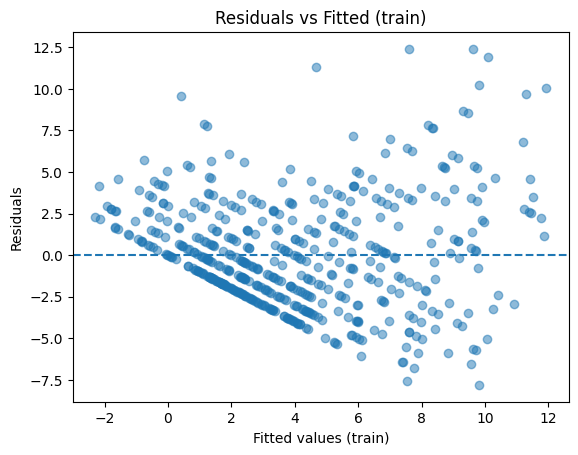

In [61]:
# 8.2 Plot residuals vs fitted
# -----------------------------
plt.figure()
plt.scatter(train_fitted, train_resid, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Fitted values (train)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (train)")
plt.show()

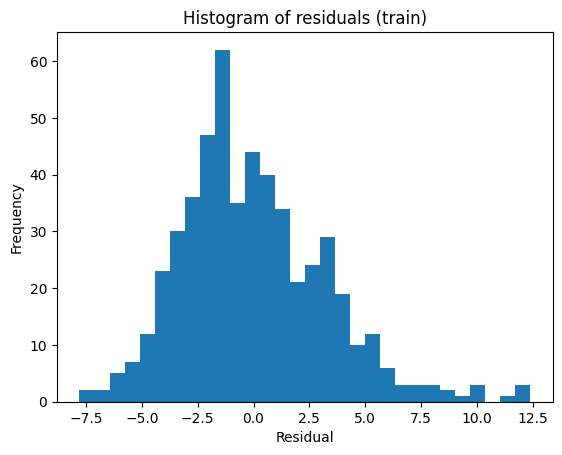

In [62]:
# 8.3 Histogram of residuals
# ---------------------------
plt.figure()
plt.hist(train_resid, bins=30)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of residuals (train)")
plt.show()

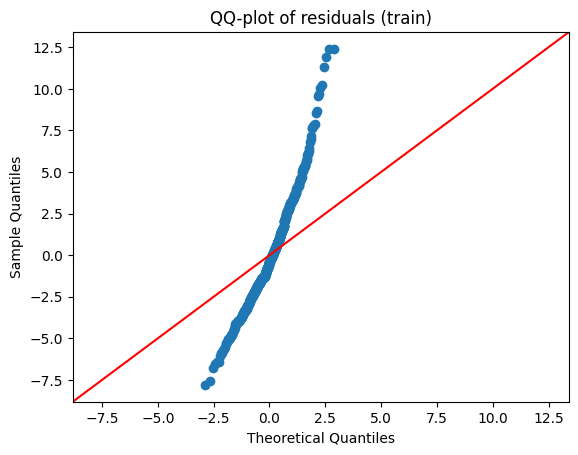

In [63]:
# 8.4 QQ-plot of residuals
# -------------------------
sm.qqplot(train_resid, line='45')
plt.title("QQ-plot of residuals (train)")
plt.show()

In [64]:
'''
# 8.5 Normality test (Jarque-Bera)
# --------------------------------
jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(train_resid)
print("\nSTEP 8.5 - Jarque-Bera normality test:")
print(f"JB statistic: {jb_stat:.3f}")
print(f"p-value:      {jb_pvalue:.3g}")
print(f"Skew:         {skew:.3f}")
print(f"Kurtosis:     {kurtosis:.3f}")
'''

'\n# 8.5 Normality test (Jarque-Bera)\n# --------------------------------\njb_stat, jb_pvalue, skew, kurtosis = jarque_bera(train_resid)\nprint("\nSTEP 8.5 - Jarque-Bera normality test:")\nprint(f"JB statistic: {jb_stat:.3f}")\nprint(f"p-value:      {jb_pvalue:.3g}")\nprint(f"Skew:         {skew:.3f}")\nprint(f"Kurtosis:     {kurtosis:.3f}")\n'

In [65]:
# 8.6 Heteroskedasticity test (Breusch-Pagan)
# -------------------------------------------
bp_test = het_breuschpagan(train_resid, X_train_hr_const)
bp_stat, bp_pvalue, f_stat, f_pvalue = bp_test

print("\nSTEP 8.6 - Breusch-Pagan test for heteroskedasticity:")
print(f"LM statistic:  {bp_stat:.3f}")
print(f"LM p-value:    {bp_pvalue:.3g}")
print(f"F-statistic:   {f_stat:.3f}")
print(f"F-test p-val:  {f_pvalue:.3g}")


STEP 8.6 - Breusch-Pagan test for heteroskedasticity:
LM statistic:  91.467
LM p-value:    7.32e-14
F-statistic:   9.021
F-test p-val:  8.54e-16


In [66]:
# 8.7 Multicollinearity check (VIF)
# ---------------------------------
# Use the same features as in the model (without the constant)
X_for_vif = X_train_hr_const.drop(columns=['const']).astype(float)

vif_data = []
for i, col in enumerate(X_for_vif.columns):
    vif_val = variance_inflation_factor(X_for_vif.values, i)
    vif_data.append((col, vif_val))

vif_df = pd.DataFrame(vif_data, columns=['feature', 'VIF'])

print("\nSTEP 8.7 - Variance Inflation Factors (VIF):")
display(vif_df)



STEP 8.7 - Variance Inflation Factors (VIF):


c:\Users\etaiw\Desktop\Projects\aviya_project\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,temp_c,12.007822
1,rain_mm,1.049889
2,wind_speed_ms,5.427305
3,is_weekend,inf
4,wd_1,2.022554
5,wd_2,2.259196
6,wd_3,1.827309
7,wd_4,1.898254
8,wd_5,inf
9,wd_6,inf


### Model v2 - Improved hourly model after diagnostics

temp_c, rain_mm, wind_speed_ms, weekday dummies (wd_1–wd_6),  
time-of-day dummies (tod_morning, tod_afternoon, tod_evening, tod_late_evening).

In [67]:
# =========================================================
# STEP 9 – Improved hourly model (v2) with simplified features
#         (use day_type instead of weekday dummies)
# =========================================================

from IPython.display import display
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---------------------------------------------------------
# 9.0 Ensure 'day_type' exists: 0 = weekday (Sun–Thu), 1 = weekend (Fri–Sat)
# ---------------------------------------------------------
if 'day_type' not in reg_hourly.columns:
    reg_hourly['day_type'] = reg_hourly['weekday'].apply(
        lambda x: 1 if x in [5, 6] else 0  # adjust if weekday coding is different
    )

'''
print("STEP 9.0 – day_type sample:")
display(reg_hourly[['datetime_hour', 'weekday', 'day_type']].head())
'''

# ---------------------------------------------------------
# 9.1 Define new, simplified feature set (v2)
#     (weather + day_type + TOD dummies)
# ---------------------------------------------------------

feature_cols_hr_v2 = [
    'temp_c',
    'rain_mm',
    'wind_speed_ms',
    'day_type',
    'tod_morning',
    'tod_afternoon',
    'tod_evening'  # baseline = night
]
'''
print("\nSTEP 9.1 – Feature columns used in v2 model:")
print(feature_cols_hr_v2)
'''

# Build X and y using the same naming convention as original v2
X_hr_v2 = reg_hourly[feature_cols_hr_v2].copy()
y_hr_v2 = reg_hourly['trips_per_hour'].copy()

'''
print("\nSTEP 9.1 – X_hr_v2 dtypes BEFORE cleaning:")
display(X_hr_v2.dtypes.to_frame('dtype'))
'''

# ---------------------------------------------------------
# 9.2 Clean X_hr_v2: ensure numeric and drop rows with NaNs
# ---------------------------------------------------------

# 9.2a – Convert all feature columns to numeric (coerce errors to NaN)
for c in X_hr_v2.columns:
    X_hr_v2[c] = pd.to_numeric(X_hr_v2[c], errors='coerce')

y_hr_v2 = pd.to_numeric(y_hr_v2, errors='coerce')

# 9.2b – Drop rows with NaNs in X or y
nan_in_X_v2 = X_hr_v2.isna().sum().sum()
nan_in_y_v2 = y_hr_v2.isna().sum()

'''
print(f"\nSTEP 9.2 – Total NaNs in X_hr_v2 BEFORE row-drop: {nan_in_X_v2}")
print(f"STEP 9.2 – Total NaNs in y_hr_v2 BEFORE row-drop: {nan_in_y_v2}")
'''

valid_mask_v2 = X_hr_v2.notna().all(axis=1) & y_hr_v2.notna()
X_hr_v2 = X_hr_v2.loc[valid_mask_v2].astype(float)
y_hr_v2 = y_hr_v2.loc[valid_mask_v2].astype(float)

# Reset index
X_hr_v2 = X_hr_v2.reset_index(drop=True)
y_hr_v2 = y_hr_v2.reset_index(drop=True)

'''
print("\nSTEP 9.2 – After dropping rows with NaNs (v2):")
print("X_hr_v2 shape:", X_hr_v2.shape)
print("y_hr_v2 shape:", y_hr_v2.shape)

print("\nSTEP 9.2 – Sample of cleaned X_hr_v2:")
display(X_hr_v2.head())
print("\nSTEP 9.2 – Sample of cleaned y_hr_v2:")
display(y_hr_v2.head())
'''

# Safety check
if X_hr_v2.shape[0] == 0:
    raise ValueError("STEP 9 – X_hr_v2 has 0 rows after cleaning. Cannot fit model.")

In [68]:
# ---------------------------------------------------------
# 9.3 Train/Test split and fit improved OLS (v2) with robust SE
# ---------------------------------------------------------

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(
    X_hr_v2,
    y_hr_v2,
    test_size=0.2,
    random_state=42  # כמו במודל המקורי; אפשר לשנות ל-shuffle=False אם תרצי סדר זמנים
)

'''
print("\nSTEP 9.3 – Train/Test shapes (v2):")
print("X_train_v2:", X_train_v2.shape)
print("X_test_v2:", X_test_v2.shape)
print("y_train_v2:", y_train_v2.shape)
print("y_test_v2:", y_test_v2.shape)
'''

# Add constant and ensure float
X_train_v2_const = sm.add_constant(X_train_v2, has_constant='add').astype(float)
X_test_v2_const  = sm.add_constant(X_test_v2,  has_constant='add').astype(float)

y_train_v2_float = y_train_v2.astype(float)
y_test_v2_float  = y_test_v2.astype(float)

# Fit OLS (v2)
ols_model_v2 = sm.OLS(y_train_v2_float, X_train_v2_const).fit()

# Get robust (HC3) covariance estimates
ols_model_v2_robust = ols_model_v2.get_robustcov_results(cov_type='HC3')

print("\nSTEP 9.3 – Improved OLS model (v2) with robust SE (HC3):")
print(ols_model_v2_robust.summary())

# Evaluate on test set (using robust model for prediction, כמו בקוד המקורי)
y_pred_v2 = ols_model_v2_robust.predict(X_test_v2_const)

r2_v2  = r2_score(y_test_v2_float, y_pred_v2)
mse_v2 = mean_squared_error(y_test_v2_float, y_pred_v2)
rmse_v2 = np.sqrt(mse_v2)

print("\nSTEP 9.3 – Improved model evaluation on test set (v2):")
print(f"Test R^2 (v2):  {r2_v2:.3f}")
print(f"Test RMSE (v2): {rmse_v2:.2f} trips per hour")


STEP 9.3 – Improved OLS model (v2) with robust SE (HC3):
                            OLS Regression Results                            
Dep. Variable:         trips_per_hour   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     43.61
Date:                Fri, 23 Jan 2026   Prob (F-statistic):           2.98e-48
Time:                        16:05:19   Log-Likelihood:                -1357.7
No. Observations:                 519   AIC:                             2731.
Df Residuals:                     511   BIC:                             2765.
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [69]:
# ---------------------------------------------------------
# 9.4 Check VIF again for v2 feature set
# ---------------------------------------------------------

X_for_vif_v2 = X_train_v2_const.drop(columns=['const']).astype(float)

vif_data_v2 = []
for i, col in enumerate(X_for_vif_v2.columns):
    vif_val = variance_inflation_factor(X_for_vif_v2.values, i)
    vif_data_v2.append((col, vif_val))

vif_df_v2 = pd.DataFrame(vif_data_v2, columns=['feature', 'VIF'])

print("\nSTEP 9.4 – VIF for improved model (v2):")
display(vif_df_v2)



STEP 9.4 – VIF for improved model (v2):


,feature,VIF
0,temp_c,5.910656
1,rain_mm,1.044522
2,wind_speed_ms,5.144629
3,day_type,1.468616
4,tod_morning,1.267152
5,tod_afternoon,1.769385
6,tod_evening,1.526265


Interpretation & report-ready summary (v2)

In [70]:
# =========================================================
# STEP 10 – Interpretation & report-ready summary (v2)
# =========================================================

from IPython.display import display
import pandas as pd
import numpy as np

print("STEP 10 – Interpretation of the improved hourly model (v2)\n")

# ---------------------------------------------------------
# 10.1 Build a compact coefficients table for key variables
# ---------------------------------------------------------

# Turn params / std errors / p-values into Series with proper index
coef_array = ols_model_v2_robust.params
se_array   = ols_model_v2_robust.bse
pval_array = ols_model_v2_robust.pvalues
names      = ols_model_v2_robust.model.exog_names  # ['const', 'temp_c', 'rain_mm', ...]

coef = pd.Series(coef_array, index=names)
se   = pd.Series(se_array,   index=names)
pval = pd.Series(pval_array, index=names)

'''
# Choose variables of interest to show in a table
interesting_vars = [
    'temp_c',
    'rain_mm',
    'wind_speed_ms',
    'wd_1', 'wd_2', 'wd_3', 'wd_4', 'wd_5', 'wd_6',
    'tod_morning', 'tod_afternoon', 'tod_evening', 'tod_late_evening'
]
'''

# Choose variables of interest to show in a table
interesting_vars = [
    'temp_c',
    'rain_mm',
    'wind_speed_ms',
    'day_type',
    'tod_morning',
    'tod_afternoon',
    'tod_evening'  # baseline is night (no dummy)
]


rows = []
for v in interesting_vars:
    if v in coef.index:
        rows.append({
            'variable': v,
            'coef': float(round(coef[v], 3)),
            'std_err': float(round(se[v], 3)),
            'p_value': float(pval[v])
        })

coef_table = pd.DataFrame(rows)

'''
print("STEP 10.1 – Key coefficients (v2):")
display(coef_table)

print("STEP 10.1 – Key coefficients (v2):")
display(coef_table)
'''

print("\nSTEP 10.1 – Model performance metrics (v2):")
print(f"R² (train, robust): approx. {ols_model_v2_robust.rsquared:.3f}")
print(f"R² (test):          {r2_v2:.3f}")
print(f"RMSE (test):        {rmse_v2:.2f} trips per hour\n")

STEP 10 – Interpretation of the improved hourly model (v2)


STEP 10.1 – Model performance metrics (v2):
R² (train, robust): approx. 0.462
R² (test):          0.523
RMSE (test):        3.45 trips per hour




STEP 11 – Residual diagnostics for improved model (v2)

STEP 11.1 – Residuals summary (train):


,residuals_stats
count,5.190000e+02
mean,-1.308822e-14
std,3.313305e+00
min,-8.221870e+00
25%,-2.299626e+00
50%,-4.643420e-01
75%,2.070135e+00
max,1.290270e+01


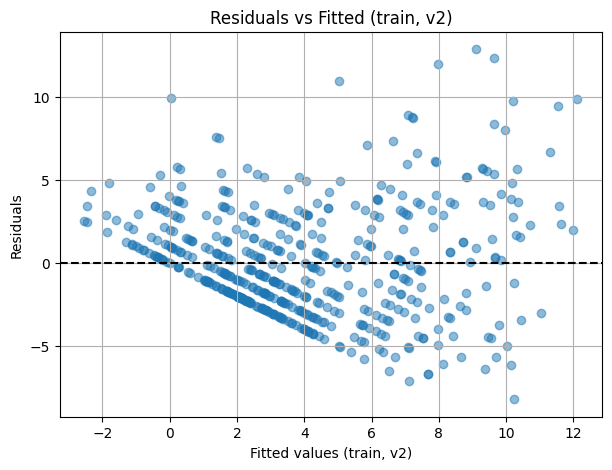

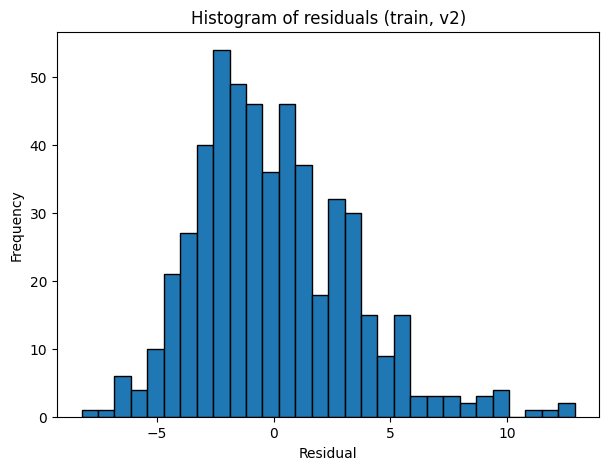

<Figure size 600x600 with 0 Axes>

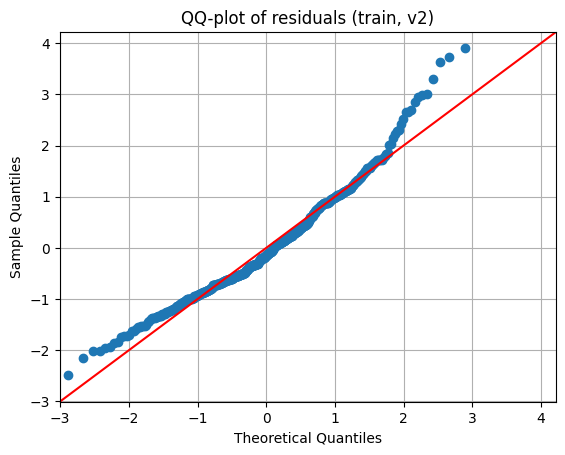


STEP 11.5 – Jarque–Bera normality test (v2):
JB statistic: 66.440
p-value:      3.74e-15
Skew:         0.744
Kurtosis:     3.927

STEP 11.6 – Breusch–Pagan test for heteroskedasticity (v2):
LM statistic:    87.073
LM p-value:      4.93e-16
F-statistic:     14.716
F-test p-value:  1.62e-17


In [71]:
# =========================================================
# STEP 11 – Residual Diagnostics for improved model (v2)
# =========================================================

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from IPython.display import display

print("\nSTEP 11 – Residual diagnostics for improved model (v2)\n")

# ---------------------------------------------------------
# 11.1 Compute fitted values and residuals (train set)
# ---------------------------------------------------------

train_fitted_v2 = ols_model_v2_robust.fittedvalues
train_resid_v2  = y_train_v2_float - train_fitted_v2

print("STEP 11.1 – Residuals summary (train):")
display(train_resid_v2.describe().to_frame(name="residuals_stats"))


# ---------------------------------------------------------
# 11.2 Residuals vs Fitted plot (v2)
# ---------------------------------------------------------

plt.figure(figsize=(7, 5))
plt.scatter(train_fitted_v2, train_resid_v2, alpha=0.5)
plt.axhline(0, linestyle='--', color='black')
plt.xlabel("Fitted values (train, v2)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (train, v2)")
plt.grid(True)
plt.show()


# ---------------------------------------------------------
# 11.3 Histogram of residuals
# ---------------------------------------------------------

plt.figure(figsize=(7, 5))
plt.hist(train_resid_v2, bins=30, edgecolor='black')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of residuals (train, v2)")
plt.grid(False)
plt.show()


# ---------------------------------------------------------
# 11.4 QQ-plot of residuals
# ---------------------------------------------------------

plt.figure(figsize=(6, 6))
sm.qqplot(train_resid_v2, line='45', fit=True)
plt.title("QQ-plot of residuals (train, v2)")
plt.grid(True)
plt.show()


# ---------------------------------------------------------
# 11.5 Normality test (Jarque–Bera)
# ---------------------------------------------------------

jb_stat, jb_pvalue, skew_v2, kurtosis_v2 = jarque_bera(train_resid_v2)

print("\nSTEP 11.5 – Jarque–Bera normality test (v2):")
print(f"JB statistic: {jb_stat:.3f}")
print(f"p-value:      {jb_pvalue:.3g}")
print(f"Skew:         {skew_v2:.3f}")
print(f"Kurtosis:     {kurtosis_v2:.3f}")


# ---------------------------------------------------------
# 11.6 Heteroskedasticity test (Breusch–Pagan)
# ---------------------------------------------------------

bp_test_v2 = het_breuschpagan(train_resid_v2, X_train_v2_const)
bp_stat_v2, bp_pvalue_v2, f_stat_v2, f_pvalue_v2 = bp_test_v2

print("\nSTEP 11.6 – Breusch–Pagan test for heteroskedasticity (v2):")
print(f"LM statistic:    {bp_stat_v2:.3f}")
print(f"LM p-value:      {bp_pvalue_v2:.3g}")
print(f"F-statistic:     {f_stat_v2:.3f}")
print(f"F-test p-value:  {f_pvalue_v2:.3g}")


#### Visual comparison: old(V1) vs new model(V2) (test set)

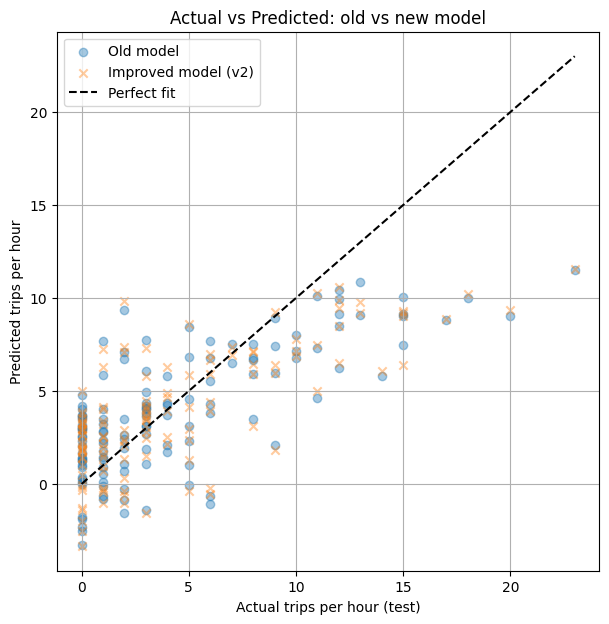

In [72]:
# =========================================================
# STEP 12.1 – Visual comparison: old vs new model (test set)
# =========================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# נהפוך את החיזויים לסדרות עם אינדקס רציף
y_test_old  = y_test_hr.reset_index(drop=True)
y_test_new  = y_test_v2_float.reset_index(drop=True)

y_pred_old_series = pd.Series(y_pred_hr).reset_index(drop=True)
y_pred_new_series = pd.Series(y_pred_v2).reset_index(drop=True)

# נוודא שאורך כולם תואם (ניקח את המינימום ליתר ביטחון)
n = min(len(y_test_old), len(y_test_new),
        len(y_pred_old_series), len(y_pred_new_series))

y_true_common   = y_test_new.iloc[:n]          # האמת (אותו y בשני המודלים)
y_pred_old_comm = y_pred_old_series.iloc[:n]   # מודל ישן
y_pred_new_comm = y_pred_new_series.iloc[:n]   # מודל חדש v2

plt.figure(figsize=(7, 7))
plt.scatter(y_true_common, y_pred_old_comm,
            alpha=0.4, label="Old model", marker='o')
plt.scatter(y_true_common, y_pred_new_comm,
            alpha=0.4, label="Improved model (v2)", marker='x')

max_val = max(y_true_common.max(),
              y_pred_old_comm.max(),
              y_pred_new_comm.max())

plt.plot([0, max_val], [0, max_val],
         '--', color='black', label="Perfect fit")

plt.xlabel("Actual trips per hour (test)")
plt.ylabel("Predicted trips per hour")
plt.title("Actual vs Predicted: old vs new model")
plt.legend()
plt.grid(True)
plt.show()


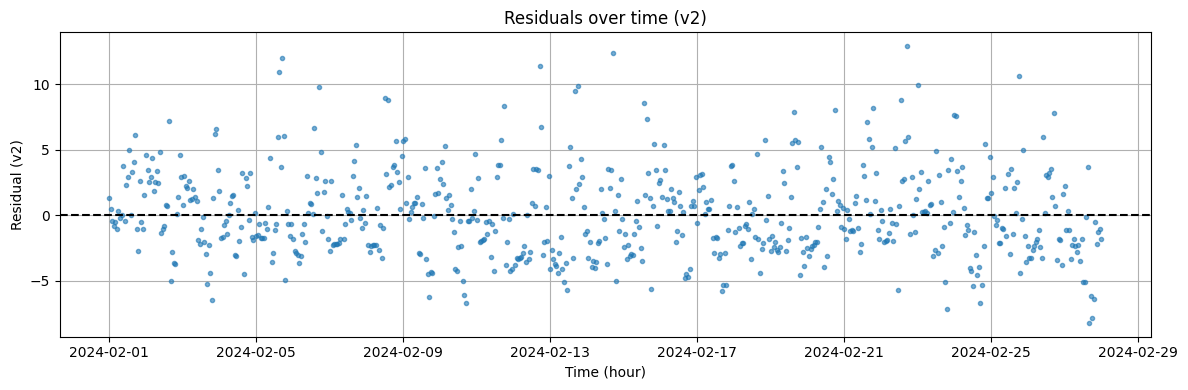

In [73]:
# =========================================================
# STEP 12.2 – Residuals over time (v2)
# =========================================================

X_all_const_v2 = sm.add_constant(X_hr_v2, has_constant='add')
y_hat_all_v2   = ols_model_v2_robust.predict(X_all_const_v2)

reg_hourly_v2 = reg_hourly.loc[X_hr_v2.index].copy()
reg_hourly_v2['y_hat_v2'] = y_hat_all_v2
reg_hourly_v2['resid_v2'] = reg_hourly_v2['trips_per_hour'] - reg_hourly_v2['y_hat_v2']

plt.figure(figsize=(12, 4))
plt.plot(reg_hourly_v2['datetime_hour'], reg_hourly_v2['resid_v2'],
         marker='.', linestyle='none', alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Time (hour)")
plt.ylabel("Residual (v2)")
plt.title("Residuals over time (v2)")
plt.grid(True)
plt.tight_layout()
plt.show()


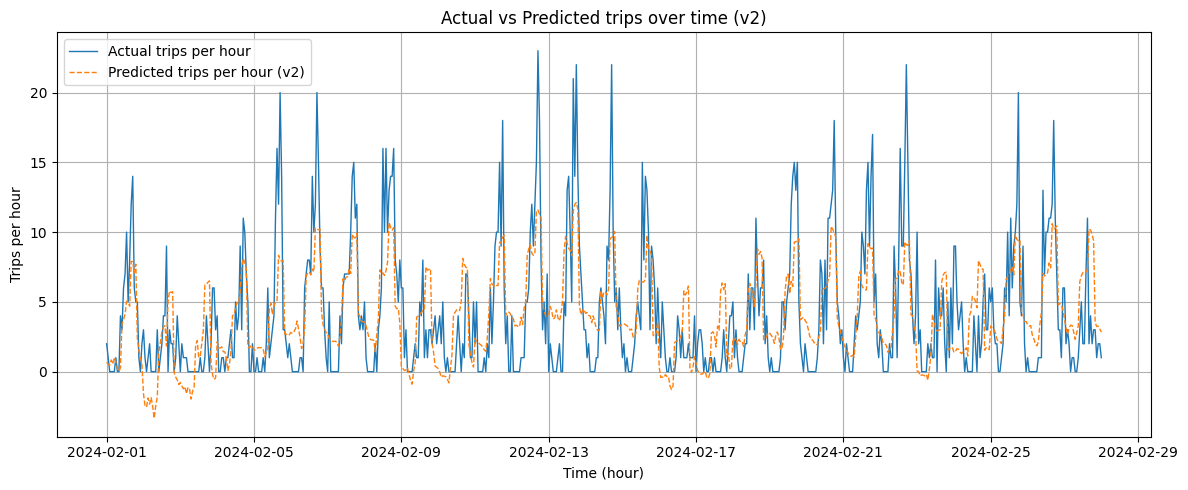

In [74]:
# =========================================================
# STEP 12.3 – Actual vs Predicted over time (v2)
# =========================================================

plt.figure(figsize=(12, 5))

plt.plot(reg_hourly_v2['datetime_hour'],
         reg_hourly_v2['trips_per_hour'],
         label="Actual trips per hour", linewidth=1)

plt.plot(reg_hourly_v2['datetime_hour'],
         reg_hourly_v2['y_hat_v2'],
         label="Predicted trips per hour (v2)",
         linewidth=1, linestyle='--')

plt.xlabel("Time (hour)")
plt.ylabel("Trips per hour")
plt.title("Actual vs Predicted trips over time (v2)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


השוואה חזותית בין המודל הראשוני לבין המודל המשופר (v2)

בגרף ההשוואה בין החיזוי לאמת (Actual vs Predicted), ניתן לראות בצורה ברורה כי המודל המשופר (v2) מספק התאמה טובה ומדויקת יותר מהמודל הראשוני. נקודות החיזוי של המודל החדש (מסומנות ב-X) מרוכזות קרוב יותר לקו האלכסון המייצג התאמה מושלמת, בעוד שהמודל הישן מציג פיזור רחב יותר והרבה נקודות רחוקות משמעותית מהקו. משמעות הדבר היא שהמודל v2 מצליח ללכוד טוב יותר את הקשרים בין המשתנים לבין מספר הנסיעות בפועל.

בנוסף, בגרף "Actual vs Predicted לאורך הזמן" ניתן לראות שהמודל המשופר מסוגל לעקוב בצורה יציבה יותר אחר התנודות האמיתיות במספר הנסיעות. הפער בין הקו האמיתי לקו החיזוי קטן יותר, במיוחד בשעות השיא ובתקופות שבהן קיימת דינמיקה מהירה. המודל הראשוני נטה לאמוד-חסר בשעות מסוימות ולאמוד-יתר באחרות, בעוד שמודל v2 מציג עקביות טובה יותר לאורך כל הטווח.

לבסוף, גם גרף השאריות (Residuals Over Time) מצביע על שיפור: השאריות של המודל המשופר קרובות יותר לאפס ומראות פחות דפוסים ברורים, מה שמעיד על יציבות גבוהה יותר ועל ירידה בהטיה שיטתית.

### Model v3 – Enhanced Linear Regression With Dynamics (v3)

temp_c, rain_mm, wind_speed_ms, day_type (weekday/weekend),  
time-of-day (tod_morning, tod_afternoon, tod_evening),  
hour of day (hour),  
previous-hour demand (lag_1),  
and an interaction term temp_x_evening (temperature × evening).


STEP 12 – Building enhanced model (v3)

STEP 12.1 – Sample of engineered features:


,temp_c,tod_evening,temp_x_evening,hour,lag_1
0,9.266667,False,0.0,1,2.0
1,10.583333,False,0.0,2,1.0
2,12.766667,False,0.0,3,0.0
3,12.650000,False,0.0,4,0.0
4,10.383333,False,0.0,5,0.0



STEP 12.2 – v3 feature set:
['temp_c', 'rain_mm', 'wind_speed_ms', 'day_type', 'tod_morning', 'tod_afternoon', 'tod_evening', 'hour', 'lag_1', 'temp_x_evening']

STEP 12.2 – dtypes BEFORE cleaning:


,dtype
temp_c,float64
rain_mm,float64
wind_speed_ms,float64
day_type,int64
tod_morning,bool
tod_afternoon,bool
tod_evening,bool
hour,int32
lag_1,float64
temp_x_evening,float64



STEP 12.3 – Total NaNs in X_v3 BEFORE row-drop: 0
STEP 12.3 – Total NaNs in y_v3 BEFORE row-drop: 0

STEP 12.3 – Shapes AFTER cleaning:
X_v3_clean shape: (648, 10)
y_v3_clean shape: (648,)

STEP 12.4 – dtypes AFTER scaling:


,dtype
temp_c,float64
rain_mm,float64
wind_speed_ms,float64
day_type,float64
tod_morning,float64
tod_afternoon,float64
tod_evening,float64
hour,float64
lag_1,float64
temp_x_evening,float64



STEP 12.5 – Train/Test shapes (v3):
X_train_v3: (518, 10)
X_test_v3: (130, 10)
y_train_v3: (518,)
y_test_v3: (130,)

STEP 12.6 – OLS model v3 summary (robust SE):
                            OLS Regression Results                            
Dep. Variable:         trips_per_hour   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     60.12
Date:                Fri, 23 Jan 2026   Prob (F-statistic):           1.27e-79
Time:                        16:05:21   Log-Likelihood:                -1252.1
No. Observations:                 518   AIC:                             2526.
Df Residuals:                     507   BIC:                             2573.
Df Model:                          10                                         
Covariance Type:                  HC3                                         
                     coef    std err          

,feature,VIF
0,temp_c,1.732549
1,rain_mm,1.167184
2,wind_speed_ms,1.170390
3,day_type,1.635088
4,tod_morning,1.147380
5,tod_afternoon,2.055382
6,tod_evening,94.185987
7,hour,3.387563
8,lag_1,3.512055
9,temp_x_evening,97.927534


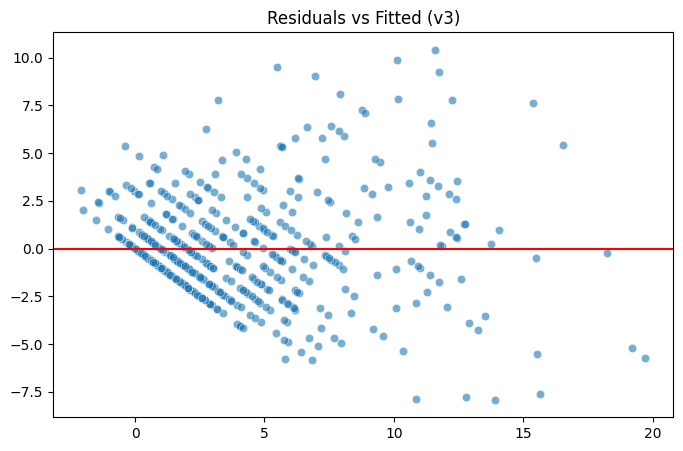

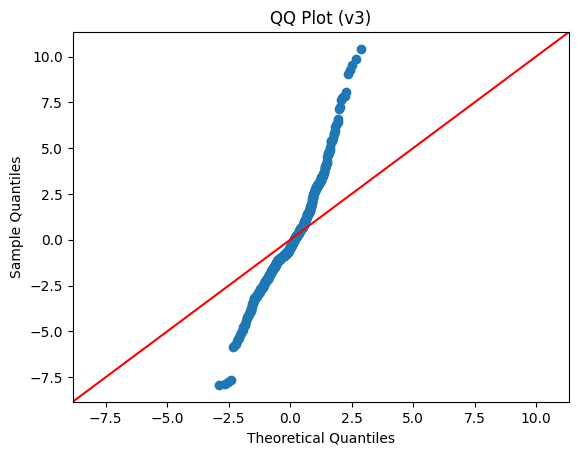

In [75]:
# =========================================================
# STEP 12 – Alternative Enhanced Model (v3)
#         (lag features, hour-of-day, interactions, scaling)
# =========================================================

from IPython.display import display
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

print("\nSTEP 12 – Building enhanced model (v3)\n")

# ---------------------------------------------------------
# 12.1 Create engineered features (v3)
# ---------------------------------------------------------

reg_hourly_v3 = reg_hourly.copy()

# Hour of day (continuous)
reg_hourly_v3['hour'] = reg_hourly_v3['datetime_hour'].dt.hour

# Lag-1 (previous hour)
reg_hourly_v3['lag_1'] = reg_hourly_v3['trips_per_hour'].shift(1)

# Interaction: temperature × evening
reg_hourly_v3['temp_x_evening'] = reg_hourly_v3['temp_c'] * reg_hourly_v3['tod_evening']

# Drop lag-induced NaN
reg_hourly_v3 = reg_hourly_v3.dropna(subset=['lag_1']).reset_index(drop=True)

print("STEP 12.1 – Sample of engineered features:")
display(reg_hourly_v3[['temp_c','tod_evening','temp_x_evening','hour','lag_1']].head())

# ---------------------------------------------------------
# 12.2 Define v3 feature set
# ---------------------------------------------------------

feature_cols_v3 = [
    'temp_c',
    'rain_mm',
    'wind_speed_ms',
    'day_type',
    'tod_morning',
    'tod_afternoon',
    'tod_evening',
    'hour',
    'lag_1',
    'temp_x_evening'
]

print("\nSTEP 12.2 – v3 feature set:")
print(feature_cols_v3)

X_v3 = reg_hourly_v3[feature_cols_v3].copy()
y_v3 = reg_hourly_v3['trips_per_hour'].copy()

print("\nSTEP 12.2 – dtypes BEFORE cleaning:")
display(X_v3.dtypes.to_frame('dtype'))

# ---------------------------------------------------------
# 12.3 Clean X_v3 / y_v3: ensure numeric + drop NaNs
# ---------------------------------------------------------

# Convert all feature columns to numeric
for c in X_v3.columns:
    X_v3[c] = pd.to_numeric(X_v3[c], errors='coerce')

y_v3 = pd.to_numeric(y_v3, errors='coerce')

nan_in_X_v3 = X_v3.isna().sum().sum()
nan_in_y_v3 = y_v3.isna().sum()

print(f"\nSTEP 12.3 – Total NaNs in X_v3 BEFORE row-drop: {nan_in_X_v3}")
print(f"STEP 12.3 – Total NaNs in y_v3 BEFORE row-drop: {nan_in_y_v3}")

valid_mask_v3 = X_v3.notna().all(axis=1) & y_v3.notna()
X_v3_clean = X_v3.loc[valid_mask_v3].astype(float)
y_v3_clean = y_v3.loc[valid_mask_v3].astype(float)

X_v3_clean = X_v3_clean.reset_index(drop=True)
y_v3_clean = y_v3_clean.reset_index(drop=True)

print("\nSTEP 12.3 – Shapes AFTER cleaning:")
print("X_v3_clean shape:", X_v3_clean.shape)
print("y_v3_clean shape:", y_v3_clean.shape)

# ---------------------------------------------------------
# 12.4 Scale selected numerical features
# ---------------------------------------------------------

scaler = StandardScaler()
X_v3_clean[['temp_c', 'wind_speed_ms']] = scaler.fit_transform(
    X_v3_clean[['temp_c','wind_speed_ms']]
)

print("\nSTEP 12.4 – dtypes AFTER scaling:")
display(X_v3_clean.dtypes.to_frame('dtype'))

# ---------------------------------------------------------
# 12.5 Train/Test split
# ---------------------------------------------------------

X_train_v3, X_test_v3, y_train_v3, y_test_v3 = train_test_split(
    X_v3_clean, y_v3_clean, test_size=0.2, shuffle=False
)

X_train_v3_const = sm.add_constant(X_train_v3).astype(float)
X_test_v3_const  = sm.add_constant(X_test_v3).astype(float)

print("\nSTEP 12.5 – Train/Test shapes (v3):")
print("X_train_v3:", X_train_v3.shape)
print("X_test_v3:", X_test_v3.shape)
print("y_train_v3:", y_train_v3.shape)
print("y_test_v3:", y_test_v3.shape)

# ---------------------------------------------------------
# 12.6 Fit OLS (v3) + robust SE (HC3)
# ---------------------------------------------------------

ols_model_v3 = sm.OLS(y_train_v3, X_train_v3_const).fit()
ols_model_v3_robust = ols_model_v3.get_robustcov_results(cov_type="HC3")

print("\nSTEP 12.6 – OLS model v3 summary (robust SE):")
print(ols_model_v3_robust.summary())

# ---------------------------------------------------------
# 12.7 Evaluate test performance
# ---------------------------------------------------------

y_pred_v3 = ols_model_v3_robust.predict(X_test_v3_const)

r2_v3 = r2_score(y_test_v3, y_pred_v3)
mse_v3 = mean_squared_error(y_test_v3, y_pred_v3)
rmse_v3 = np.sqrt(mse_v3)

print("\nSTEP 12.7 – v3 Model Performance:")
print(f"Test R^2 (v3):  {r2_v3:.3f}")
print(f"Test RMSE (v3): {rmse_v3:.2f} trips per hour")

# ---------------------------------------------------------
# 12.8 VIF diagnostics
# ---------------------------------------------------------

X_for_vif_v3 = X_train_v3_const.drop(columns=['const'])

vif_data_v3 = []
for i, col in enumerate(X_for_vif_v3.columns):
    vif_val = variance_inflation_factor(X_for_vif_v3.values, i)
    vif_data_v3.append((col, vif_val))

vif_df_v3 = pd.DataFrame(vif_data_v3, columns=['feature','VIF'])

print("\nSTEP 12.8 – VIF for v3:")
display(vif_df_v3)

# ---------------------------------------------------------
# 12.9 Residual diagnostics
# ---------------------------------------------------------

residuals_v3 = ols_model_v3_robust.resid
fitted_v3 = ols_model_v3_robust.fittedvalues

plt.figure(figsize=(8,5))
sns.scatterplot(x=fitted_v3, y=residuals_v3, alpha=0.6)
plt.axhline(0, color='red')
plt.title("Residuals vs Fitted (v3)")
plt.show()

sm.qqplot(residuals_v3, line='45')
plt.title("QQ Plot (v3)")
plt.show()


### Model v4 – Regularized Linear Regression (Ridge + OLS) (v4)

Same as v3 but excluding tod_evening:   
temp_c, rain_mm, wind_speed_ms, day_type, tod_morning, tod_afternoon, hour, lag_1, temp_x_evening.


STEP 13 – Building regularized model (v4, Ridge + OLS)

STEP 13.1 – v4 feature set:
['temp_c', 'rain_mm', 'wind_speed_ms', 'day_type', 'tod_morning', 'tod_afternoon', 'hour', 'lag_1', 'temp_x_evening']

STEP 13.3 – Chosen alpha for Ridge v4: 10.0

STEP 13.3 – Ridge v4 Model Performance (test):
Test R^2 (Ridge v4):  0.444
Test RMSE (Ridge v4): 3.28 trips per hour


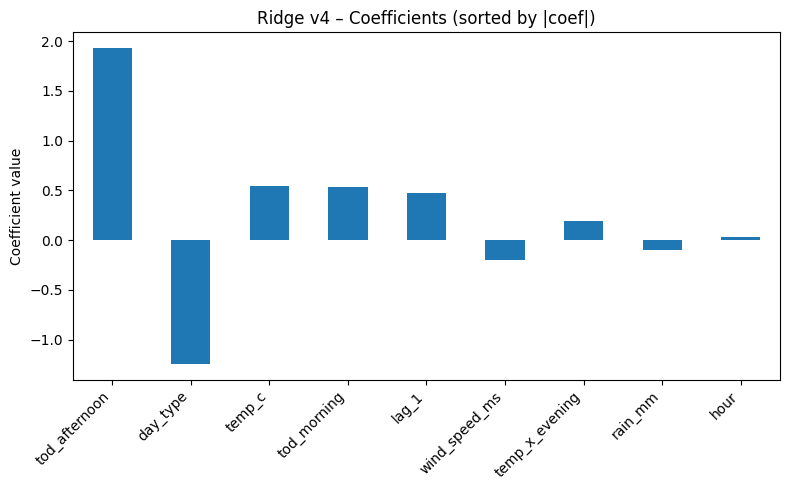


STEP 13.4 – OLS v4 (robust HC3) – Regression table:
                            OLS Regression Results                            
Dep. Variable:         trips_per_hour   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     66.73
Date:                Fri, 23 Jan 2026   Prob (F-statistic):           2.27e-80
Time:                        16:05:21   Log-Likelihood:                -1259.1
No. Observations:                 518   AIC:                             2538.
Df Residuals:                     508   BIC:                             2581.
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

,residual
count,5.180000e+02
mean,-1.783215e-16
std,2.752915e+00
min,-8.112592e+00
25%,-1.560380e+00
50%,-4.123977e-01
75%,1.372145e+00
max,1.156538e+01


Residual mean (should be close to 0): -0.0000


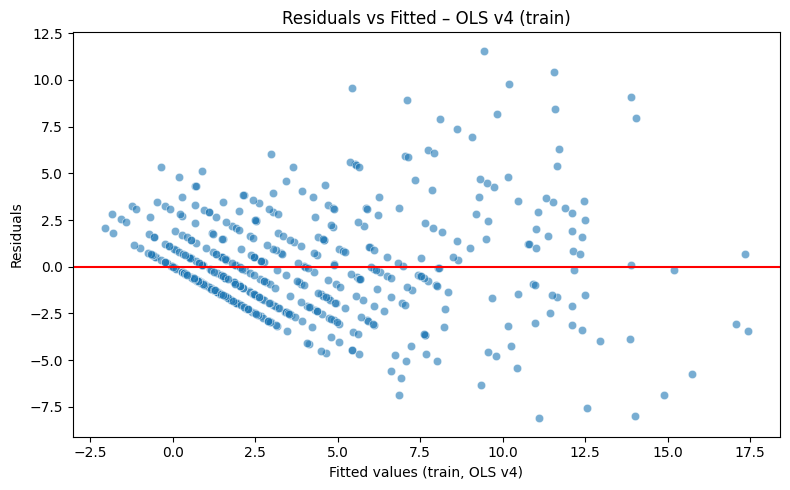

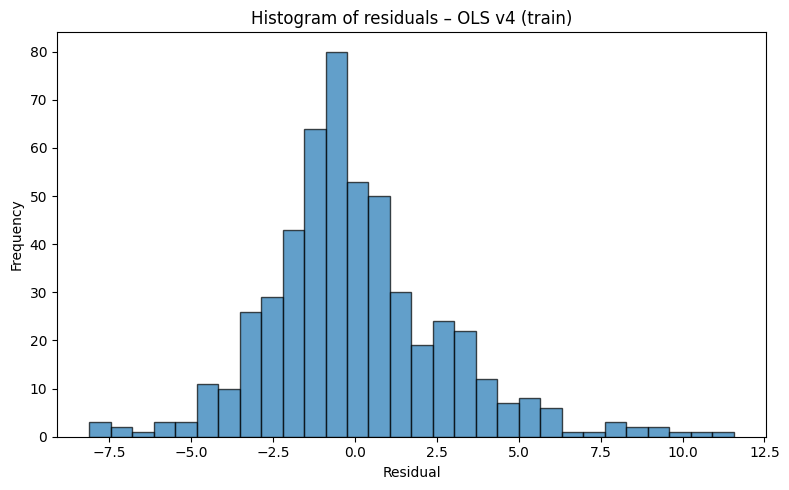

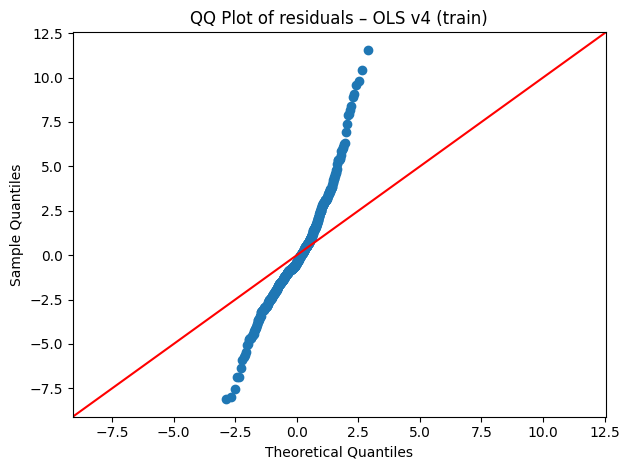

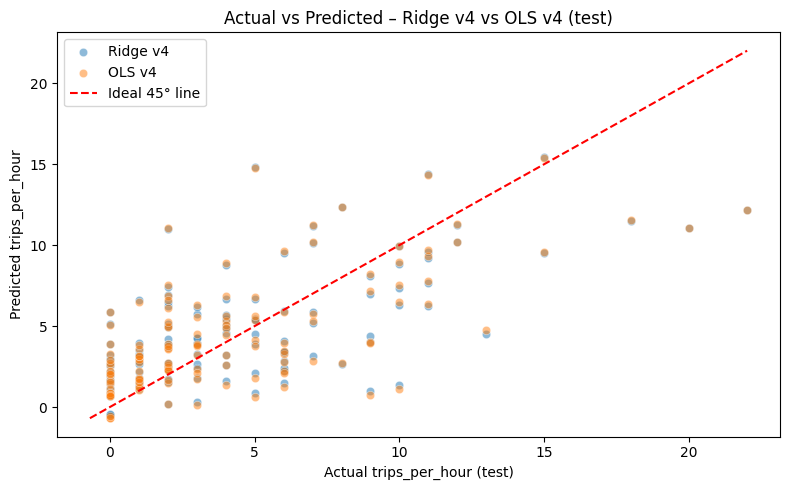

In [76]:
# =========================================================
# STEP 13 – Alternative Regularized Model (v4)
#         Ridge for prediction + OLS for regression table
# =========================================================

from IPython.display import display
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

print("\nSTEP 13 – Building regularized model (v4, Ridge + OLS)\n")

# ---------------------------------------------------------
# 13.1 – Define v4 feature set (drop 'tod_evening')
# ---------------------------------------------------------

feature_cols_v4 = [c for c in X_v3_clean.columns if c != 'tod_evening']

print("STEP 13.1 – v4 feature set:")
print(feature_cols_v4)

X_v4 = X_v3_clean[feature_cols_v4].copy()
y_v4 = y_v3_clean.copy()

# ---------------------------------------------------------
# 13.2 – Train/Test split (no shuffle, like v3)
# ---------------------------------------------------------

X_train_v4, X_test_v4, y_train_v4, y_test_v4 = train_test_split(
    X_v4, y_v4, test_size=0.2, shuffle=False
)

# ---------------------------------------------------------
# 13.3 – Ridge regression (prediction-focused)
# ---------------------------------------------------------

alphas = [0.1, 1.0, 10.0, 50.0, 100.0]

ridge_v4 = RidgeCV(alphas=alphas, cv=5)
ridge_v4.fit(X_train_v4, y_train_v4)

print("\nSTEP 13.3 – Chosen alpha for Ridge v4:", ridge_v4.alpha_)

y_pred_v4_ridge = ridge_v4.predict(X_test_v4)

r2_v4_ridge = r2_score(y_test_v4, y_pred_v4_ridge)
mse_v4_ridge = mean_squared_error(y_test_v4, y_pred_v4_ridge)
rmse_v4_ridge = np.sqrt(mse_v4_ridge)

print("\nSTEP 13.3 – Ridge v4 Model Performance (test):")
print(f"Test R^2 (Ridge v4):  {r2_v4_ridge:.3f}")
print(f"Test RMSE (Ridge v4): {rmse_v4_ridge:.2f} trips per hour")

coef_v4_ridge = pd.Series(ridge_v4.coef_, index=feature_cols_v4)
coef_v4_sorted = coef_v4_ridge.sort_values(key=lambda s: np.abs(s), ascending=False)

'''
print("\nSTEP 13.3 – Ridge v4 coefficients (sorted by |coef|):")
display(coef_v4_sorted.to_frame('coef'))
'''

plt.figure(figsize=(8,5))
coef_v4_sorted.plot(kind='bar')
plt.title("Ridge v4 – Coefficients (sorted by |coef|)")
plt.ylabel("Coefficient value")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 13.4 – OLS version of v4 (for linear regression table)
# ---------------------------------------------------------

# Add constant for statsmodels
X_train_v4_sm = sm.add_constant(X_train_v4).astype(float)
X_test_v4_sm  = sm.add_constant(X_test_v4).astype(float)

ols_v4 = sm.OLS(y_train_v4, X_train_v4_sm).fit()
ols_v4_robust = ols_v4.get_robustcov_results(cov_type="HC3")

print("\nSTEP 13.4 – OLS v4 (robust HC3) – Regression table:")
print(ols_v4_robust.summary())

# ---------------------------------------------------------
# 13.5 – OLS v4 performance (for comparison with Ridge)
# ---------------------------------------------------------

y_pred_v4_ols = ols_v4_robust.predict(X_test_v4_sm)

r2_v4_ols = r2_score(y_test_v4, y_pred_v4_ols)
mse_v4_ols = mean_squared_error(y_test_v4, y_pred_v4_ols)
rmse_v4_ols = np.sqrt(mse_v4_ols)

print("\nSTEP 13.5 – OLS v4 Model Performance (test):")
print(f"Test R^2 (OLS v4):  {r2_v4_ols:.3f}")
print(f"Test RMSE (OLS v4): {rmse_v4_ols:.2f} trips per hour")

# ---------------------------------------------------------
# 13.6 – Residuals (train, OLS v4) – summary
# ---------------------------------------------------------

y_train_pred_v4_ols = ols_v4_robust.fittedvalues
residuals_v4_ols = y_train_v4 - y_train_pred_v4_ols

residuals_summary_v4 = pd.Series(residuals_v4_ols).describe()
print("\nSTEP 13.6 – Residuals summary (train, OLS v4):")
display(residuals_summary_v4.to_frame('residual'))

print(f"Residual mean (should be close to 0): {residuals_v4_ols.mean():.4f}")

# ---------------------------------------------------------
# 13.7 – Residuals vs Fitted (OLS v4)
# ---------------------------------------------------------

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_train_pred_v4_ols, y=residuals_v4_ols, alpha=0.6)
plt.axhline(0, color='red')
plt.xlabel("Fitted values (train, OLS v4)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted – OLS v4 (train)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 13.8 – Histogram + QQ-plot of residuals (OLS v4)
# ---------------------------------------------------------

plt.figure(figsize=(8,5))
plt.hist(residuals_v4_ols, bins=30, edgecolor='black', alpha=0.7)
plt.title("Histogram of residuals – OLS v4 (train)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

sm.qqplot(residuals_v4_ols, line='45')
plt.title("QQ Plot of residuals – OLS v4 (train)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 13.9 – Actual vs Predicted (test) – both Ridge & OLS
# ---------------------------------------------------------

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test_v4, y=y_pred_v4_ridge, alpha=0.5, label='Ridge v4')
sns.scatterplot(x=y_test_v4, y=y_pred_v4_ols, alpha=0.5, label='OLS v4')
lims = [
    min(y_test_v4.min(), y_pred_v4_ridge.min(), y_pred_v4_ols.min()),
    max(y_test_v4.max(), y_pred_v4_ridge.max(), y_pred_v4_ols.max())
]
plt.plot(lims, lims, 'r--', label='Ideal 45° line')
plt.xlabel("Actual trips_per_hour (test)")
plt.ylabel("Predicted trips_per_hour")
plt.title("Actual vs Predicted – Ridge v4 vs OLS v4 (test)")
plt.legend()
plt.tight_layout()
plt.show()


### Model v5 – Non-Linear Gradient Boosted Trees (XGBoost) (v5)

Full engineered feature set:  
temp_c, rain_mm, wind_speed_ms, day_type, tod_morning, tod_afternoon, tod_evening, hour, lag_1, temp_x_evening.


STEP 14 – Training XGBoost Regressor (v5)

Shapes: (518, 10) (130, 10)

STEP 14.2 – XGBoost Performance (test):
Test R^2 (v5):  0.423
Test RMSE (v5): 3.35 trips per hour

STEP 14.3 – Feature Importance (Gain):


,importance_gain
lag_1,42.118023
temp_x_evening,27.744730
day_type,21.833136
tod_evening,14.389636
hour,13.672058
tod_afternoon,12.498544
rain_mm,5.547693
temp_c,5.186588
wind_speed_ms,3.763933
tod_morning,2.761417


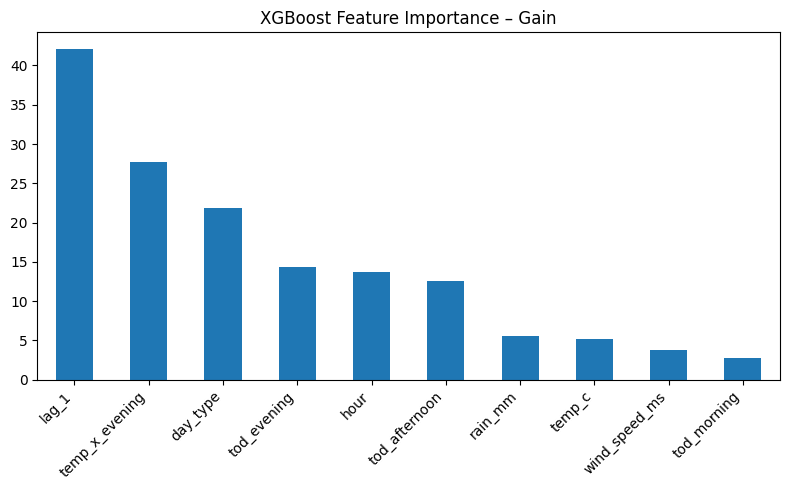


STEP 14.4 – SHAP summary plot (global importance):


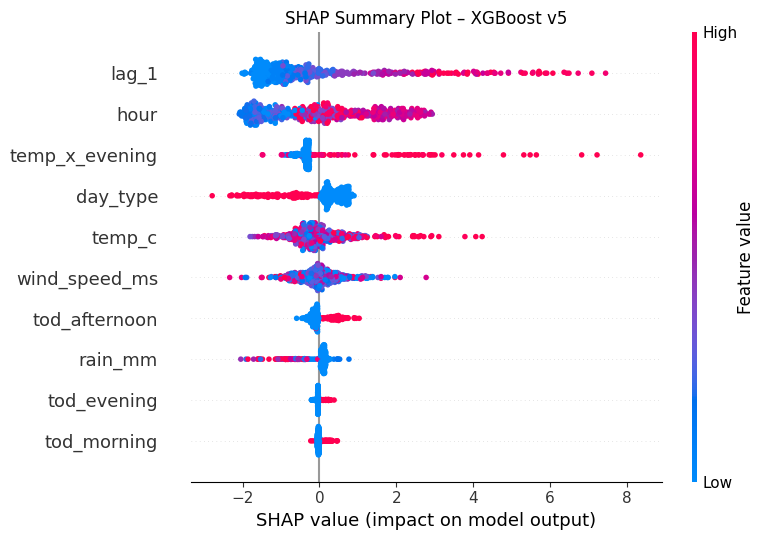


SHAP dependence for: temp_c


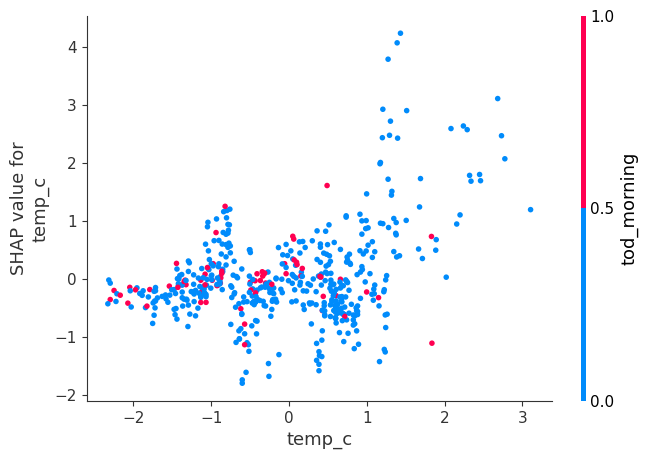


SHAP dependence for: rain_mm


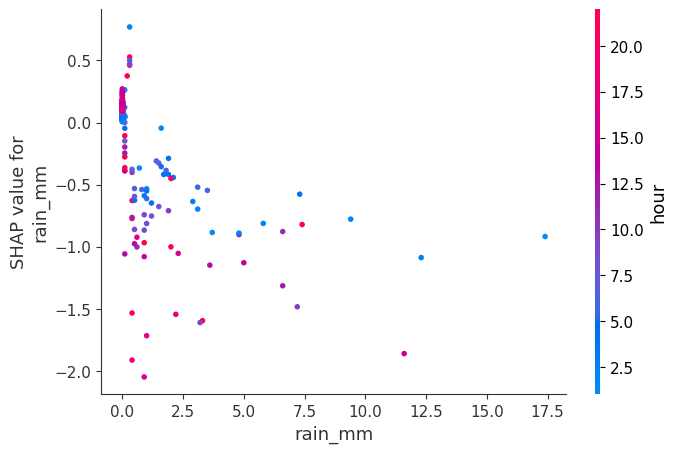


SHAP dependence for: wind_speed_ms


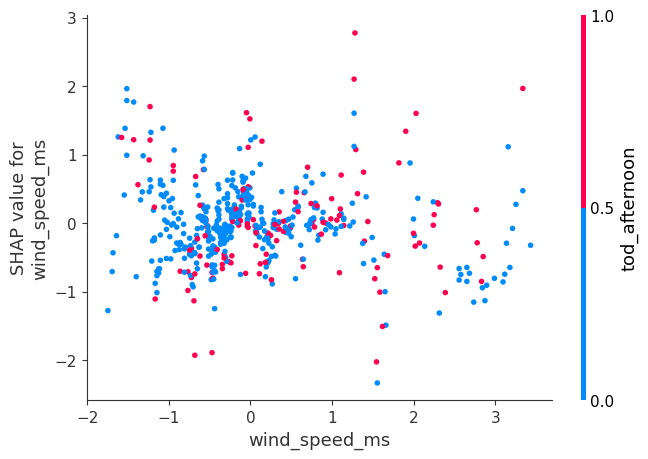


SHAP dependence for: lag_1


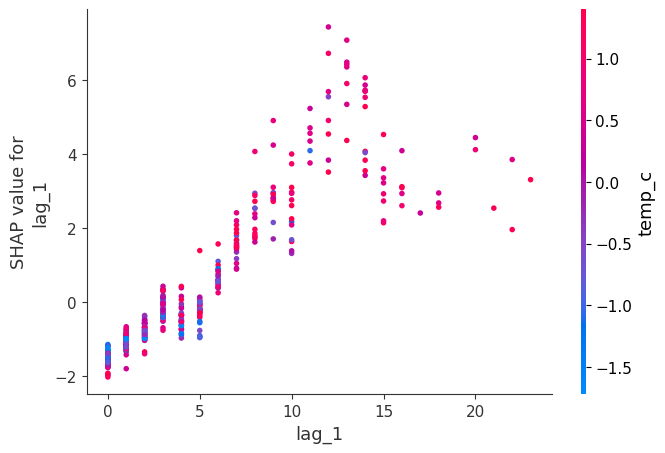


SHAP dependence for: tod_afternoon


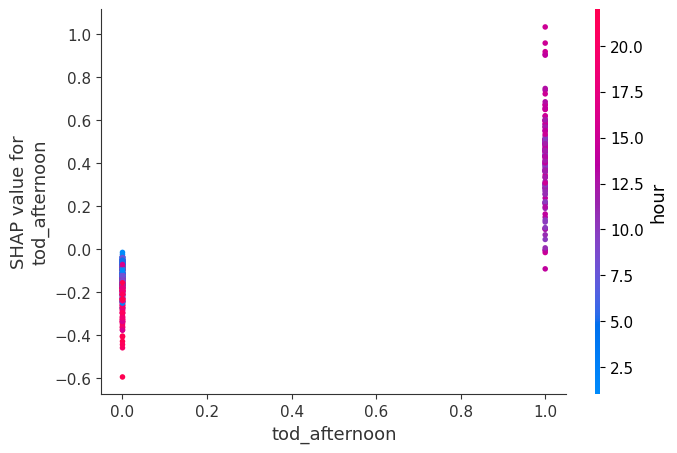

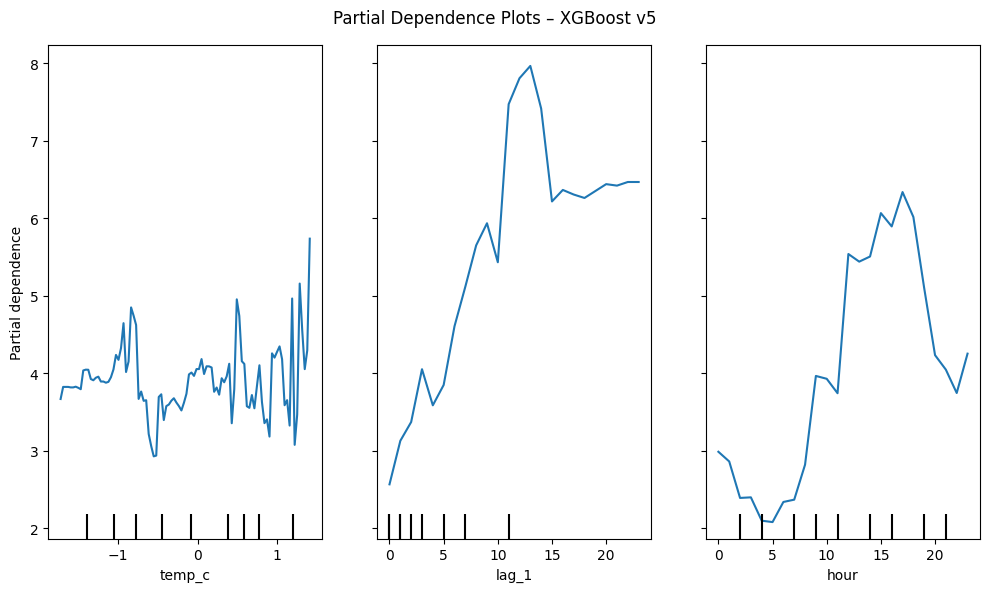

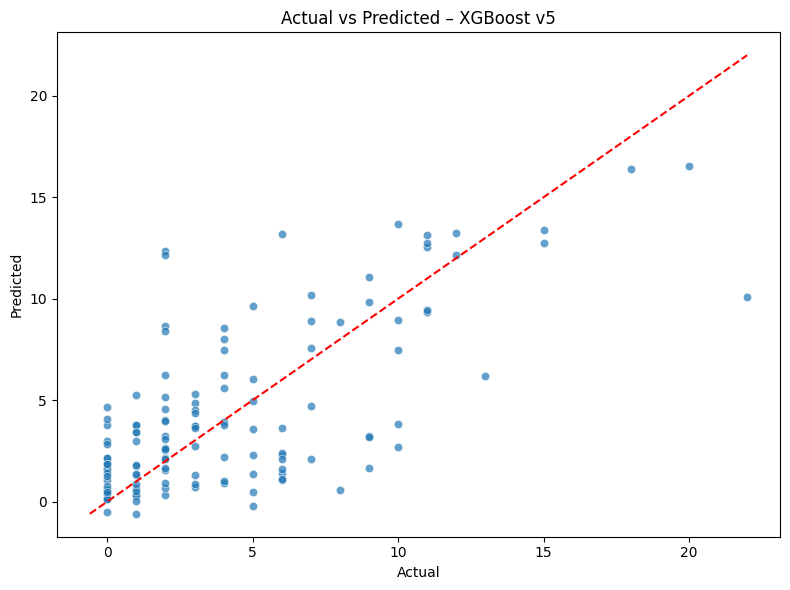

In [77]:
# =========================================================
# STEP 14 – XGBoost Regressor (v5)
#       Non-linear model for improved predictive performance
# =========================================================

import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import PartialDependenceDisplay
import shap
import matplotlib.pyplot as plt
import seaborn as sns

print("\nSTEP 14 – Training XGBoost Regressor (v5)\n")

# ---------------------------------------------------------
# 14.1 – Use the same cleaned data as v3/v4
# ---------------------------------------------------------

X_v5 = X_v3_clean.copy()
y_v5 = y_v3_clean.copy()

# Train/test split (same as v3 and v4)
from sklearn.model_selection import train_test_split
X_train_v5, X_test_v5, y_train_v5, y_test_v5 = train_test_split(
    X_v5, y_v5, test_size=0.2, shuffle=False
)

print("Shapes:", X_train_v5.shape, X_test_v5.shape)

# ---------------------------------------------------------
# 14.2 – Train XGBoost model
# ---------------------------------------------------------

xgb_model = xgb.XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

xgb_model.fit(X_train_v5, y_train_v5)

# Predictions
y_pred_v5 = xgb_model.predict(X_test_v5)

# Metrics
r2_v5 = r2_score(y_test_v5, y_pred_v5)
rmse_v5 = np.sqrt(mean_squared_error(y_test_v5, y_pred_v5))

print("\nSTEP 14.2 – XGBoost Performance (test):")
print(f"Test R^2 (v5):  {r2_v5:.3f}")
print(f"Test RMSE (v5): {rmse_v5:.2f} trips per hour")

# ---------------------------------------------------------
# 14.3 – Feature Importance (Gain, Weight, Cover)
# ---------------------------------------------------------

importance_gain = xgb_model.get_booster().get_score(importance_type='gain')
importance_weight = xgb_model.get_booster().get_score(importance_type='weight')

importance_gain = pd.Series(importance_gain).sort_values(ascending=False)
importance_weight = pd.Series(importance_weight).sort_values(ascending=False)

print("\nSTEP 14.3 – Feature Importance (Gain):")
display(importance_gain.to_frame("importance_gain"))

plt.figure(figsize=(8,5))
importance_gain.plot(kind='bar')
plt.title("XGBoost Feature Importance – Gain")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 14.4 – SHAP values (global feature effects)
# ---------------------------------------------------------

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_v5)

print("\nSTEP 14.4 – SHAP summary plot (global importance):")
plt.title("SHAP Summary Plot – XGBoost v5")
shap.summary_plot(shap_values, X_train_v5, show=False)
plt.show()

# ---------------------------------------------------------
# 14.5 – SHAP dependence (effect of individual features)
# ---------------------------------------------------------

for feature in ['temp_c', 'rain_mm', 'wind_speed_ms', 'lag_1', 'tod_afternoon']:
    print(f"\nSHAP dependence for: {feature}")
    shap.dependence_plot(feature, shap_values, X_train_v5, show=False)
    plt.show()

# ---------------------------------------------------------
# 14.6 – Partial Dependence Plots (global non-linear effect)
# ---------------------------------------------------------

features_to_plot = ['temp_c', 'lag_1', 'hour']

disp = PartialDependenceDisplay.from_estimator(
    xgb_model,
    X_train_v5,
    features_to_plot,
    kind='average'
)

plt.gcf().set_size_inches(10, 6)
plt.suptitle("Partial Dependence Plots – XGBoost v5")
plt.tight_layout()
plt.show()


# ---------------------------------------------------------
# 14.7 – Actual vs Predicted Plot (test)
# ---------------------------------------------------------

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_v5, y=y_pred_v5, alpha=0.7)
min_val = min(y_test_v5.min(), y_pred_v5.min())
max_val = max(y_test_v5.max(), y_pred_v5.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted – XGBoost v5")
plt.tight_layout()
plt.show()


### Model 6 - Weekday OLS

In [78]:
# =========================================================
# STEP X – Weekday-Only Linear Model (v6)
# =========================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

print("STEP X – Building Weekday-Only OLS Model (v6)\n")

# ---------------------------------------------------------
# 1. Filter only weekdays (Sun–Thu). day_type = 0
# ---------------------------------------------------------
reg_week = reg_hourly[reg_hourly['day_type'] == 0].copy()

print("Remaining rows after weekday-only filter:", len(reg_week))

# ---------------------------------------------------------
# 2. Create weekday dummies (Sunday–Thursday)
# ---------------------------------------------------------
weekday_dummies = pd.get_dummies(reg_week['weekday'], prefix='wd', drop_first=True)

# ---------------------------------------------------------
# 3. Select features (no hours, no interaction, no lag)
# ---------------------------------------------------------
X_v6 = pd.concat([
    reg_week[['temp_c', 'rain_mm', 'wind_speed_ms']].reset_index(drop=True),
    weekday_dummies.reset_index(drop=True)
], axis=1)

y_v6 = reg_week['trips_per_hour'].astype(float)

# ---------------------------------------------------------
# 4. Clean and convert
# ---------------------------------------------------------
X_v6 = X_v6.apply(pd.to_numeric, errors='coerce')
valid_mask = X_v6.notna().all(axis=1) & y_v6.notna()

X_v6 = X_v6[valid_mask].astype(float)
y_v6 = y_v6[valid_mask].astype(float)

print("Shapes after cleaning:", X_v6.shape, y_v6.shape)

# ---------------------------------------------------------
# 5. Train/test split (no shuffle for time series)
# ---------------------------------------------------------
X_train_v6, X_test_v6, y_train_v6, y_test_v6 = train_test_split(
    X_v6, y_v6, test_size=0.2, shuffle=False
)

# ---------------------------------------------------------
# 6. Add constant and fit OLS
# ---------------------------------------------------------
X_train_v6_const = sm.add_constant(X_train_v6)
X_test_v6_const  = sm.add_constant(X_test_v6)

ols_model_v6 = sm.OLS(y_train_v6, X_train_v6_const).fit()

print("\nSTEP X – OLS Weekday-Only Model (v6):")
print(ols_model_v6.summary())

# ---------------------------------------------------------
# 7. Evaluate
# ---------------------------------------------------------
y_pred_v6 = ols_model_v6.predict(X_test_v6_const)

r2_v6 = r2_score(y_test_v6, y_pred_v6)
rmse_v6 = np.sqrt(mean_squared_error(y_test_v6, y_pred_v6))

print("\nSTEP X – v6 Model Performance:")
print(f"Test R² (v6):  {r2_v6:.3f}")
print(f"Test RMSE (v6): {rmse_v6:.2f} trips/hour")


STEP X – Building Weekday-Only OLS Model (v6)

Remaining rows after weekday-only filter: 457
Shapes after cleaning: (313, 7) (313,)

STEP X – OLS Weekday-Only Model (v6):
                            OLS Regression Results                            
Dep. Variable:         trips_per_hour   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     19.36
Date:                Fri, 23 Jan 2026   Prob (F-statistic):           1.72e-20
Time:                        16:05:25   Log-Likelihood:                -715.55
No. Observations:                 250   AIC:                             1447.
Df Residuals:                     242   BIC:                             1475.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err    

C:\Users\etaiw\AppData\Local\Temp\ipykernel_20596\3437064019.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_v6 = X_v6[valid_mask].astype(float)



STEP X – Building Weekday-Only OLS Model (v6)

Rows remaining after weekday filter: 457
Shapes after cleaning: (313, 7) (313,)

STEP X – OLS Weekday-Only Model (v6):
                            OLS Regression Results                            
Dep. Variable:         trips_per_hour   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     19.36
Date:                Fri, 23 Jan 2026   Prob (F-statistic):           1.72e-20
Time:                        16:05:25   Log-Likelihood:                -715.55
No. Observations:                 250   AIC:                             1447.
Df Residuals:                     242   BIC:                             1475.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err        

C:\Users\etaiw\AppData\Local\Temp\ipykernel_20596\195480553.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_v6 = X_v6[valid]


<Figure size 600x600 with 0 Axes>

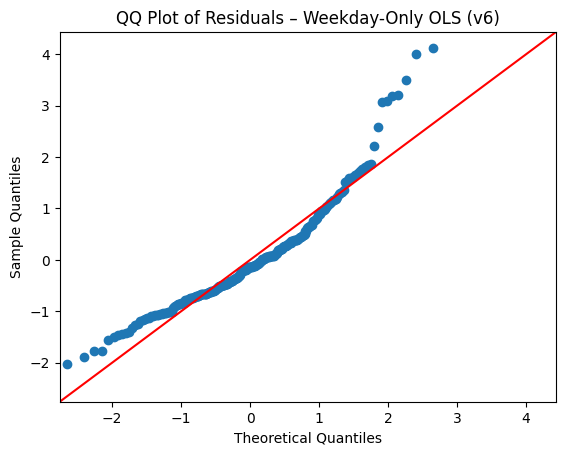

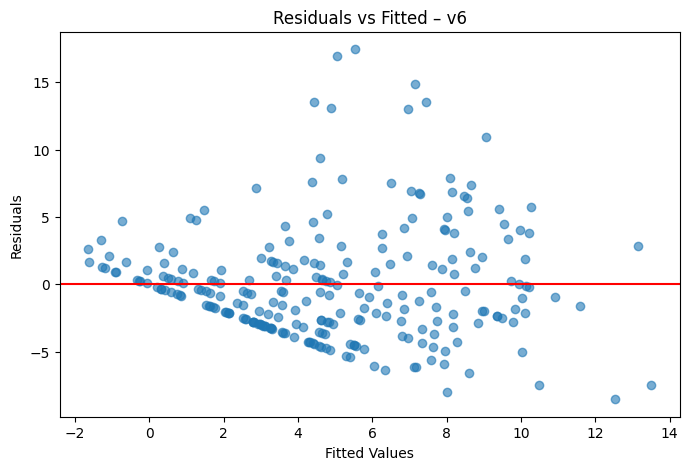

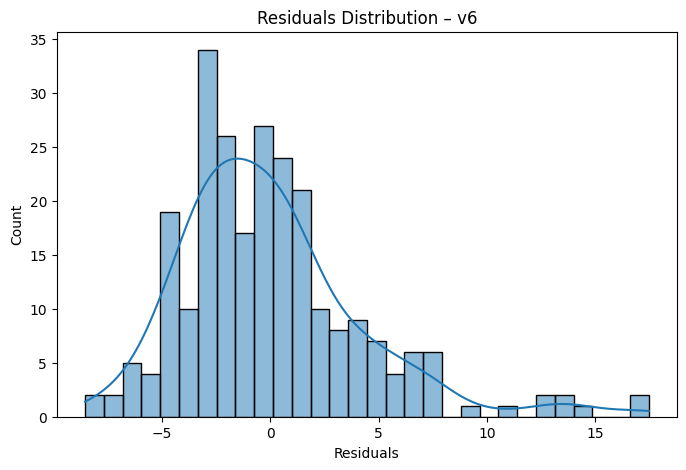

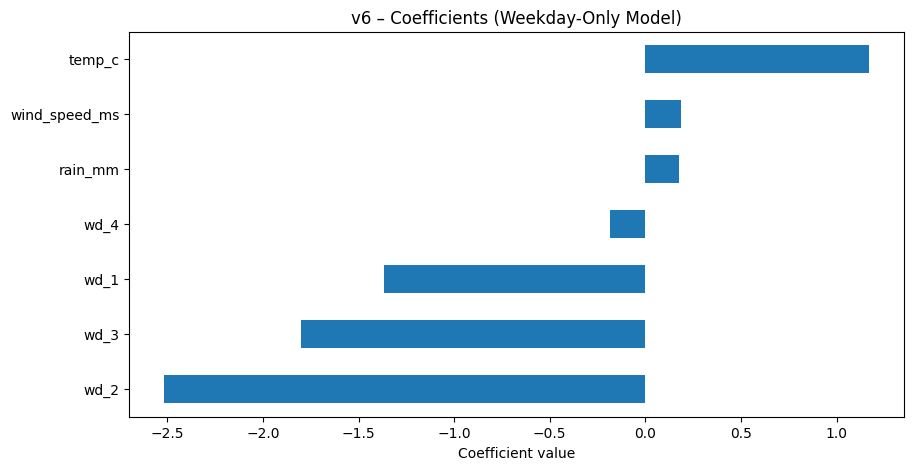

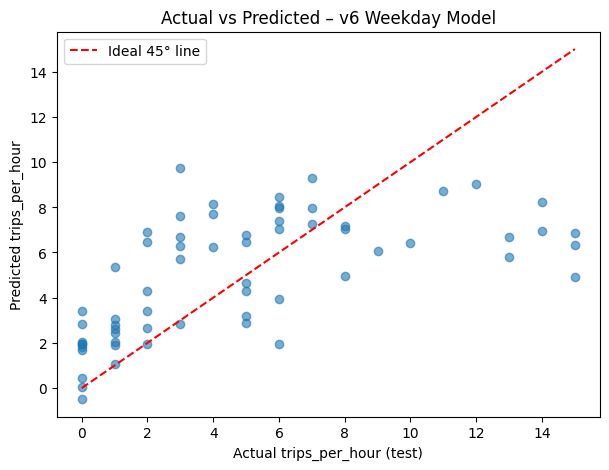

In [79]:
# =========================================================
# STEP X – Weekday-Only OLS Model (v6) + Diagnostic Plots
# =========================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

print("\nSTEP X – Building Weekday-Only OLS Model (v6)\n")

# ---------------------------------------------------------
# 1. Filter weekdays only (Sun–Thu, day_type = 0)
# ---------------------------------------------------------
reg_week = reg_hourly[reg_hourly['day_type'] == 0].copy()

print("Rows remaining after weekday filter:", len(reg_week))

# ---------------------------------------------------------
# 2. Create weekday dummies (Sunday–Thursday)
# ---------------------------------------------------------
weekday_dummies = pd.get_dummies(reg_week['weekday'], prefix='wd', drop_first=True)

# ---------------------------------------------------------
# 3. Select features (no hours, no lag, no interactions)
# ---------------------------------------------------------
X_v6 = pd.concat([
    reg_week[['temp_c', 'rain_mm', 'wind_speed_ms']].reset_index(drop=True),
    weekday_dummies.reset_index(drop=True)
], axis=1)

y_v6 = reg_week['trips_per_hour'].astype(float)

# ---------------------------------------------------------
# 4. Clean
# ---------------------------------------------------------
X_v6 = X_v6.apply(pd.to_numeric, errors='coerce')
valid = X_v6.notna().all(axis=1) & y_v6.notna()

X_v6 = X_v6[valid]
y_v6 = y_v6[valid]

print("Shapes after cleaning:", X_v6.shape, y_v6.shape)

# ---------------------------------------------------------
# 5. Train/Test split
# ---------------------------------------------------------
X_train_v6, X_test_v6, y_train_v6, y_test_v6 = train_test_split(
    X_v6, y_v6, test_size=0.2, shuffle=False
)

X_train_v6_const = sm.add_constant(X_train_v6)
X_test_v6_const  = sm.add_constant(X_test_v6)

X_train_v6_const = X_train_v6_const.astype(float)
X_test_v6_const  = X_test_v6_const.astype(float)
y_train_v6 = y_train_v6.astype(float)
y_test_v6  = y_test_v6.astype(float)

# ---------------------------------------------------------
# 6. Fit OLS model
# ---------------------------------------------------------
ols_model_v6 = sm.OLS(y_train_v6, X_train_v6_const).fit()


print("\nSTEP X – OLS Weekday-Only Model (v6):")
print(ols_model_v6.summary())

# ---------------------------------------------------------
# 7. Predict + performance
# ---------------------------------------------------------
y_pred_v6 = ols_model_v6.predict(X_test_v6_const)

r2_v6 = r2_score(y_test_v6, y_pred_v6)
rmse_v6 = np.sqrt(mean_squared_error(y_test_v6, y_pred_v6))

print("\nSTEP X – v6 Model Performance:")
print(f"Test R² (v6):  {r2_v6:.3f}")
print(f"Test RMSE (v6): {rmse_v6:.2f} trips/hour")

# =========================================================
#               Diagnostic Plots for v6
# =========================================================

residuals_v6 = ols_model_v6.resid
fitted_v6 = ols_model_v6.fittedvalues

# ---------------------------------------------------------
# A. QQ Plot
# ---------------------------------------------------------
plt.figure(figsize=(6,6))
qqplot(residuals_v6, line='45', fit=True)
plt.title("QQ Plot of Residuals – Weekday-Only OLS (v6)")
plt.show()

# ---------------------------------------------------------
# B. Residuals vs Fitted
# ---------------------------------------------------------
plt.figure(figsize=(8,5))
plt.scatter(fitted_v6, residuals_v6, alpha=0.6)
plt.axhline(0, color='red')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted – v6")
plt.show()

# ---------------------------------------------------------
# C. Histogram of Residuals
# ---------------------------------------------------------
plt.figure(figsize=(8,5))
sns.histplot(residuals_v6, kde=True, bins=30)
plt.title("Residuals Distribution – v6")
plt.xlabel("Residuals")
plt.show()

# ---------------------------------------------------------
# D. Coefficients Bar Plot
# ---------------------------------------------------------
coef_v6 = ols_model_v6.params.drop("const")

plt.figure(figsize=(10,5))
coef_v6.sort_values().plot(kind='barh')
plt.title("v6 – Coefficients (Weekday-Only Model)")
plt.xlabel("Coefficient value")
plt.show()

# ---------------------------------------------------------
# E. Actual vs Predicted (test set)
# ---------------------------------------------------------
plt.figure(figsize=(7,5))
plt.scatter(y_test_v6, y_pred_v6, alpha=0.6)
plt.plot([y_test_v6.min(), y_test_v6.max()],
         [y_test_v6.min(), y_test_v6.max()],
         '--r', label="Ideal 45° line")
plt.xlabel("Actual trips_per_hour (test)")
plt.ylabel("Predicted trips_per_hour")
plt.title("Actual vs Predicted – v6 Weekday Model")
plt.legend()
plt.show()


In [80]:
# =========================================================
# STEP X.1 – Weekday OLS v6b: add temp^2 + robust SE (HC3)
# =========================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

print("\nSTEP X.1 – Weekday-Only OLS Model (v6b: temp^2 + HC3)\n")

# 1) Filter weekdays only
reg_week = reg_hourly[reg_hourly['day_type'] == 0].copy()

# 2) Feature engineering: temp^2
reg_week['temp_sq'] = reg_week['temp_c'] ** 2

# 3) Weekday dummies
weekday_dummies = pd.get_dummies(reg_week['weekday'], prefix='wd', drop_first=True)

# 4) Build X and y
X_v6b = pd.concat([
    reg_week[['temp_c', 'temp_sq', 'rain_mm', 'wind_speed_ms']].reset_index(drop=True),
    weekday_dummies.reset_index(drop=True)
], axis=1)

y_v6b = reg_week['trips_per_hour']

# 5) Clean numeric
X_v6b = X_v6b.apply(pd.to_numeric, errors='coerce')
y_v6b = pd.to_numeric(y_v6b, errors='coerce')

valid_mask_v6b = X_v6b.notna().all(axis=1) & y_v6b.notna()
X_v6b = X_v6b[valid_mask_v6b].astype(float)
y_v6b = y_v6b[valid_mask_v6b].astype(float)

print("Shapes after cleaning v6b:", X_v6b.shape, y_v6b.shape)

# 6) Train/test split
X_train_v6b, X_test_v6b, y_train_v6b, y_test_v6b = train_test_split(
    X_v6b, y_v6b, test_size=0.2, shuffle=False
)

X_train_v6b_const = sm.add_constant(X_train_v6b).astype(float)
X_test_v6b_const  = sm.add_constant(X_test_v6b).astype(float)
y_train_v6b = y_train_v6b.astype(float)
y_test_v6b  = y_test_v6b.astype(float)

# 7) Fit OLS + robust SE
ols_model_v6b = sm.OLS(y_train_v6b, X_train_v6b_const).fit()
ols_model_v6b_robust = ols_model_v6b.get_robustcov_results(cov_type='HC3')

print("\nSTEP X.1 – OLS v6b (weekday + temp^2, robust HC3):")
print(ols_model_v6b_robust.summary())

# 8) Performance
y_pred_v6b = ols_model_v6b_robust.predict(X_test_v6b_const)
r2_v6b = r2_score(y_test_v6b, y_pred_v6b)
mse_v6b = mean_squared_error(y_test_v6b, y_pred_v6b)
rmse_v6b = np.sqrt(mse_v6b)

print("\nSTEP X.1 – v6b Model Performance:")
print(f"Test R² (v6b):  {r2_v6b:.3f}")
print(f"Test RMSE (v6b): {rmse_v6b:.2f} trips/hour")



STEP X.1 – Weekday-Only OLS Model (v6b: temp^2 + HC3)

Shapes after cleaning v6b: (313, 8) (313,)

STEP X.1 – OLS v6b (weekday + temp^2, robust HC3):
                            OLS Regression Results                            
Dep. Variable:         trips_per_hour   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     25.91
Date:                Fri, 23 Jan 2026   Prob (F-statistic):           1.03e-28
Time:                        16:05:26   Log-Likelihood:                -715.50
No. Observations:                 250   AIC:                             1449.
Df Residuals:                     241   BIC:                             1481.
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                    coef    std err          t      P>|t|  

C:\Users\etaiw\AppData\Local\Temp\ipykernel_20596\1070923484.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_v6b = X_v6b[valid_mask_v6b].astype(float)


In [81]:
# =========================================================
# STEP X.2 – Weekday OLS v6c: log-transform of trips
# =========================================================

print("\nSTEP X.2 – Weekday-Only OLS Model (v6c: log1p(trips))\n")

reg_week = reg_hourly[reg_hourly['day_type'] == 0].copy()

# Feature: temp^2 (אפשר להמשיך להשתמש בו גם פה)
reg_week['temp_sq'] = reg_week['temp_c'] ** 2

# Target: log(1 + trips)
reg_week['log_trips'] = np.log1p(reg_week['trips_per_hour'])

weekday_dummies = pd.get_dummies(reg_week['weekday'], prefix='wd', drop_first=True)

X_v6c = pd.concat([
    reg_week[['temp_c', 'temp_sq', 'rain_mm', 'wind_speed_ms']].reset_index(drop=True),
    weekday_dummies.reset_index(drop=True)
], axis=1)

y_v6c = reg_week['log_trips']

X_v6c = X_v6c.apply(pd.to_numeric, errors='coerce')
y_v6c = pd.to_numeric(y_v6c, errors='coerce')

valid_mask_v6c = X_v6c.notna().all(axis=1) & y_v6c.notna()
X_v6c = X_v6c[valid_mask_v6c].astype(float)
y_v6c = y_v6c[valid_mask_v6c].astype(float)

print("Shapes after cleaning v6c:", X_v6c.shape, y_v6c.shape)

X_train_v6c, X_test_v6c, y_train_v6c, y_test_v6c = train_test_split(
    X_v6c, y_v6c, test_size=0.2, shuffle=False
)

X_train_v6c_const = sm.add_constant(X_train_v6c).astype(float)
X_test_v6c_const  = sm.add_constant(X_test_v6c).astype(float)

ols_model_v6c = sm.OLS(y_train_v6c, X_train_v6c_const).fit()
ols_model_v6c_robust = ols_model_v6c.get_robustcov_results(cov_type='HC3')

print("\nSTEP X.2 – OLS v6c (weekday, temp^2, log-trips, robust HC3):")
print(ols_model_v6c_robust.summary())

# Performance – על סולם ה-log
y_pred_log_v6c = ols_model_v6c_robust.predict(X_test_v6c_const)

# חזרה לסולם trips_per_hour
y_pred_v6c = np.expm1(y_pred_log_v6c)
y_test_trips_v6c = np.expm1(y_test_v6c)

r2_v6c = r2_score(y_test_trips_v6c, y_pred_v6c)
mse_v6c = mean_squared_error(y_test_trips_v6c, y_pred_v6c)
rmse_v6c = np.sqrt(mse_v6c)

print("\nSTEP X.2 – v6c Model Performance (back-transformed):")
print(f"Test R² (v6c):  {r2_v6c:.3f}")
print(f"Test RMSE (v6c): {rmse_v6c:.2f} trips/hour")



STEP X.2 – Weekday-Only OLS Model (v6c: log1p(trips))

Shapes after cleaning v6c: (313, 8) (313,)

STEP X.2 – OLS v6c (weekday, temp^2, log-trips, robust HC3):
                            OLS Regression Results                            
Dep. Variable:              log_trips   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     36.88
Date:                Fri, 23 Jan 2026   Prob (F-statistic):           7.64e-38
Time:                        16:05:26   Log-Likelihood:                -280.10
No. Observations:                 250   AIC:                             578.2
Df Residuals:                     241   BIC:                             609.9
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                    coef    std err          t   

C:\Users\etaiw\AppData\Local\Temp\ipykernel_20596\537278855.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_v6c = X_v6c[valid_mask_v6c].astype(float)


In [82]:
# =========================================================
# STEP X.3 – Weekday OLS v6d: add daily lag (lag_24)
# =========================================================

print("\nSTEP X.3 – Weekday-Only OLS Model (v6d: + daily lag)\n")

reg_week = reg_hourly[reg_hourly['day_type'] == 0].copy()

# daily lag: trips 24h before (previous weekday same hour)
reg_week['lag_24'] = reg_week['trips_per_hour'].shift(24)

# temp^2 again
reg_week['temp_sq'] = reg_week['temp_c'] ** 2

weekday_dummies = pd.get_dummies(reg_week['weekday'], prefix='wd', drop_first=True)

X_v6d = pd.concat([
    reg_week[['temp_c', 'temp_sq', 'rain_mm', 'wind_speed_ms', 'lag_24']].reset_index(drop=True),
    weekday_dummies.reset_index(drop=True)
], axis=1)

y_v6d = reg_week['trips_per_hour']

X_v6d = X_v6d.apply(pd.to_numeric, errors='coerce')
y_v6d = pd.to_numeric(y_v6d, errors='coerce')

valid_mask_v6d = X_v6d.notna().all(axis=1) & y_v6d.notna()
X_v6d = X_v6d[valid_mask_v6d].astype(float)
y_v6d = y_v6d[valid_mask_v6d].astype(float)

print("Shapes after cleaning v6d:", X_v6d.shape, y_v6d.shape)

X_train_v6d, X_test_v6d, y_train_v6d, y_test_v6d = train_test_split(
    X_v6d, y_v6d, test_size=0.2, shuffle=False
)

X_train_v6d_const = sm.add_constant(X_train_v6d).astype(float)
X_test_v6d_const  = sm.add_constant(X_test_v6d).astype(float)

ols_model_v6d = sm.OLS(y_train_v6d, X_train_v6d_const).fit()
ols_model_v6d_robust = ols_model_v6d.get_robustcov_results(cov_type='HC3')

print("\nSTEP X.3 – OLS v6d (weekday, temp^2, lag_24, robust HC3):")
print(ols_model_v6d_robust.summary())

y_pred_v6d = ols_model_v6d_robust.predict(X_test_v6d_const)
r2_v6d = r2_score(y_test_v6d, y_pred_v6d)
mse_v6d = mean_squared_error(y_test_v6d, y_pred_v6d)
rmse_v6d = np.sqrt(mse_v6d)

print("\nSTEP X.3 – v6d Model Performance:")
print(f"Test R² (v6d):  {r2_v6d:.3f}")
print(f"Test RMSE (v6d): {rmse_v6d:.2f} trips/hour")



STEP X.3 – Weekday-Only OLS Model (v6d: + daily lag)

Shapes after cleaning v6d: (289, 9) (289,)

STEP X.3 – OLS v6d (weekday, temp^2, lag_24, robust HC3):
                            OLS Regression Results                            
Dep. Variable:         trips_per_hour   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     38.22
Date:                Fri, 23 Jan 2026   Prob (F-statistic):           2.12e-40
Time:                        16:05:26   Log-Likelihood:                -623.01
No. Observations:                 231   AIC:                             1266.
Df Residuals:                     221   BIC:                             1300.
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                    coef    std err          t      P

C:\Users\etaiw\AppData\Local\Temp\ipykernel_20596\988470900.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_v6d = X_v6d[valid_mask_v6d].astype(float)
